In [2]:
import numpy as np
import time
import itertools as it

import matplotlib.pylab as plt
import matplotlib.lines as mlines
import matplotlib as mpl
import matplotlib.ticker as ticker
from matplotlib.animation import FuncAnimation
import pickle

# import kmos_tools as KT
import reionizer
import pandas as pd
import scipy.interpolate
import os, sys
import scipy
from scipy import interpolate, integrate
from scipy.integrate import ode, solve_ivp, odeint

# import corner
from astropy.cosmology import Planck15, z_at_value
import astropy.units as u
import astropy.constants as const

from matplotlib import rc_file
rc_file(os.environ['WORK_DIR']+'/code/matplotlibrc')

%matplotlib inline

import seaborn as sns

plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = (4,4)

sys.path.append('../')
import bubbles

In [3]:
%load_ext autoreload
%autoreload 2

# Linking Lya velocity offset to bubble size

If only Lya with a given velocity offset can escape IGM with high transmission, can we infer minimum bubble size?

# Lya cross-section

This looks fine

0.9945570919719633
0.9642391126233685


Text(0, 0.5, 'Lya cross-section [cm$^2$]')

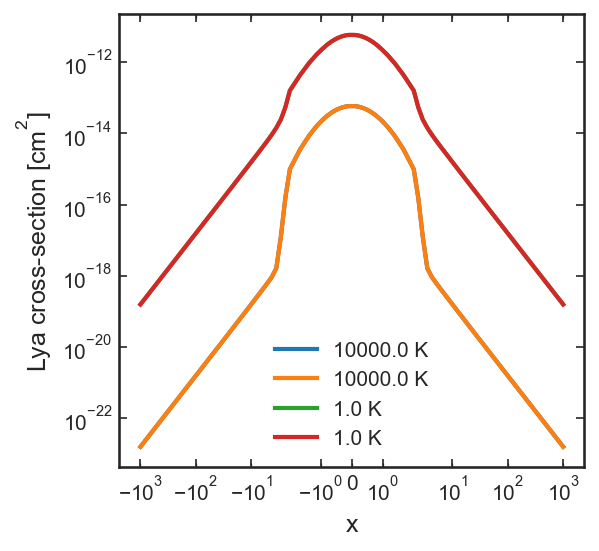

In [44]:
xtab_neg = -np.logspace(-1,3)
xtab_pos = -xtab_neg
xtab     = np.sort(np.concatenate((xtab_neg, xtab_pos)))

T_tab = [1e4*u.K, 1*u.K]

for T in T_tab:
    crosssec = bubbles.lya_cross_section(T)
    wave     = crosssec.Lya_x_to_wave(xtab)

    plt.plot(xtab, crosssec.Lya_crosssec(wave=wave), label=T)
    plt.plot(xtab, crosssec.Lya_crosssec_x(xtab), label=T)
#     plt.plot(xtab, crosssec.Voigt(xtab), label=T, alpha=0.8)
    
    print(np.sqrt(np.pi)/np.trapz(crosssec.Voigt(xtab), xtab))

plt.legend()
plt.xscale('symlog')
plt.yscale('log')

plt.xlabel('x')
plt.ylabel('Lya cross-section [cm$^2$]')

Text(0, 0.5, 'Lya cross-section [cm$^2$]')

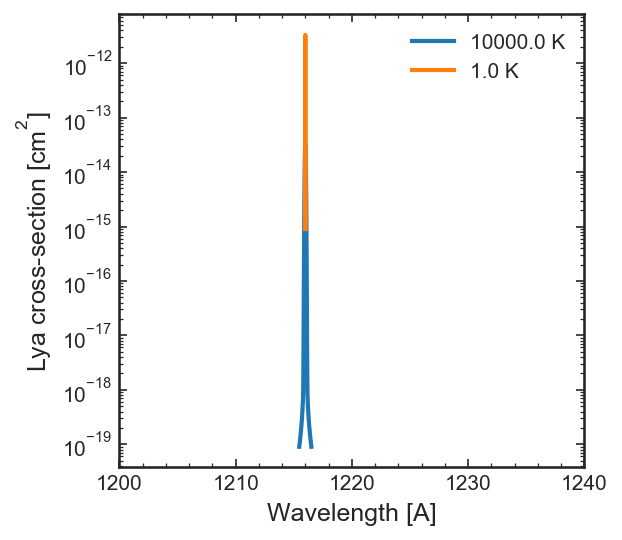

In [9]:
for T in T_tab:
    crosssec = bubbles.lya_cross_section(T)
    wave     = crosssec.Lya_x_to_wave(xtab)
    
    plt.semilogy(wave, crosssec.Lya_crosssec(wave=wave), label=T)

plt.legend()

plt.xlim(1200, 1240)
plt.xlabel('Wavelength [A]')
plt.ylabel('Lya cross-section [cm$^2$]')

## Gunn Peterson Check

<Quantity 4.64813974e-18 cm2>

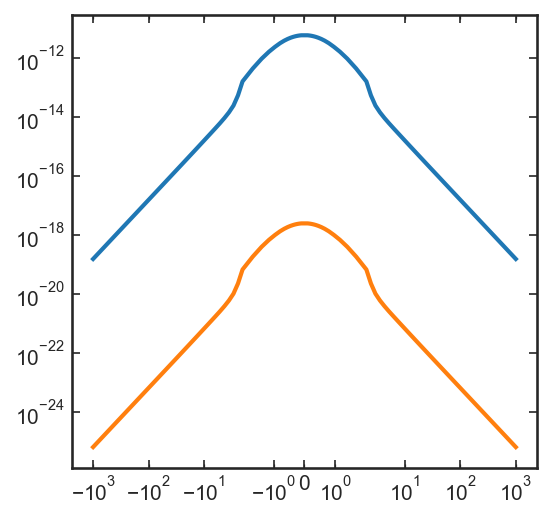

In [45]:
xtab_neg = -np.logspace(-1,3)
xtab_pos = -xtab_neg
xtab     = np.sort(np.concatenate((xtab_neg, xtab_pos)))

integrand = crosssec.Lya_crosssec_x(xtab)*crosssec.dfreq_Lya / (crosssec.dfreq_Lya*xtab + bubbles.freq_Lya)

plt.plot(xtab, crosssec.Lya_crosssec_x(xtab), label='Cross-section')
plt.plot(xtab, integrand, label='integrand')
plt.xscale('symlog')
plt.yscale('log')

np.trapz(integrand, xtab)

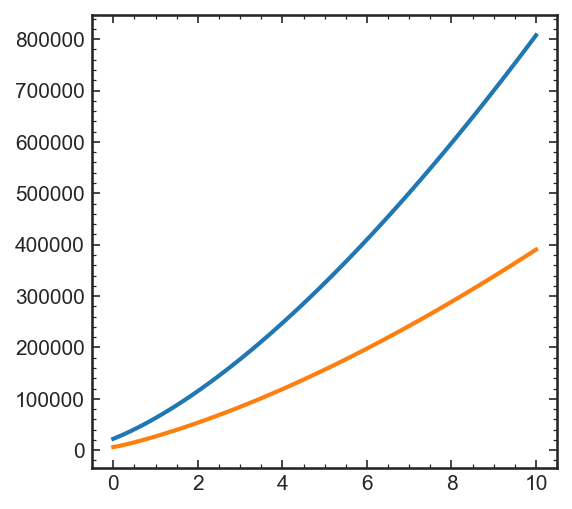

In [51]:
def tau_GP_integral(z):
    
    # Use 1/2 integral as from 0 to infinity
    integrand = crosssec.Lya_crosssec_x(xtab)*crosssec.dfreq_Lya / (crosssec.dfreq_Lya*xtab + bubbles.freq_Lya)
    tau_GP = const.c * bubbles.n_H(z)/Planck15.H(z) * 0.5*np.trapz(integrand, xtab)
    return tau_GP.to(u.cm/u.cm)

def tau_GP_approx(z):
    return 7e5 * ((1 + z)/10.)**1.5

ztab = np.linspace(0., 10)

plt.plot(ztab, tau_GP_approx(ztab))
plt.plot(ztab, tau_GP_integral(ztab))

# Estimate neutral fraction in a bubble

Use [Cen & Haiman (2000)](https://ui.adsabs.harvard.edu/abs/2000ApJ...542L..75C/abstract), [Haiman (2004)](https://ui.adsabs.harvard.edu/abs/2002ApJ...576L...1H/abstract), [Mesinger, Haiman & Cen (2004)](https://ui.adsabs.harvard.edu/abs/2004ApJ...613...23M/abstract)

## Bubble size

In [83]:
# Matthee+18
bubbles.R_bubble_CenHaiman2000(z_s=6.6, Ndot_ion=1e54/u.s, t_source=1.e7*u.yr) # proper size of ionized bubble

<Quantity 0.31447151 Mpc>

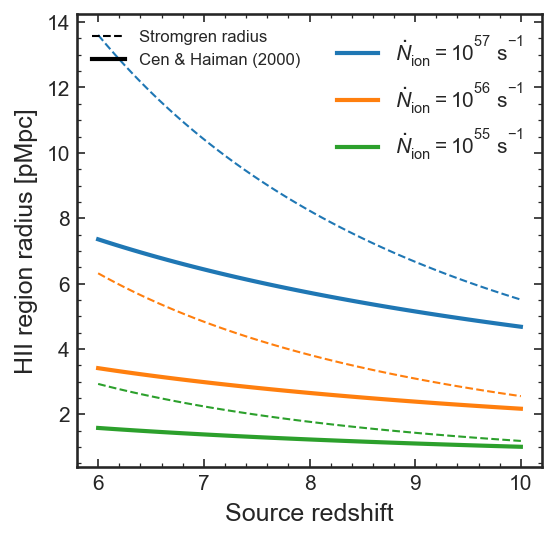

In [84]:
ztab = np.linspace(6., 10)

Ndot_ion_tab = [1.e57, 1.e56, 1.e55]

for Ndot_ion in Ndot_ion_tab:
    
    ln = plt.plot(ztab, bubbles.R_bubble_Stromgren(ztab, Ndot_ion=Ndot_ion/u.s),
                 ls='dashed', lw=1)  
    
    plt.plot(ztab, bubbles.R_bubble_CenHaiman2000(ztab, Ndot_ion=Ndot_ion/u.s, 
                                          t_source=1.e8*u.yr),
             c=ln[0].get_color(),
             label='$\dot{N}_\mathrm{ion} = 10^{%.0f}$ s$^{-1}$' % np.log10(Ndot_ion))


stromgren_line = mlines.Line2D([], [], color='k', lw=1, ls='dashed', label='Stromgren radius')
CenHaiman_line = mlines.Line2D([], [], color='k', lw=2, label='Cen & Haiman (2000)')

leg = plt.legend(handles=[stromgren_line, CenHaiman_line], loc='upper left', fontsize=8)
plt.gca().add_artist(leg)

plt.legend()

plt.xlabel('Source redshift')
plt.ylabel('HII region radius [pMpc]')

plt.savefig('../figs/R_HII_compare.pdf')

### Change age

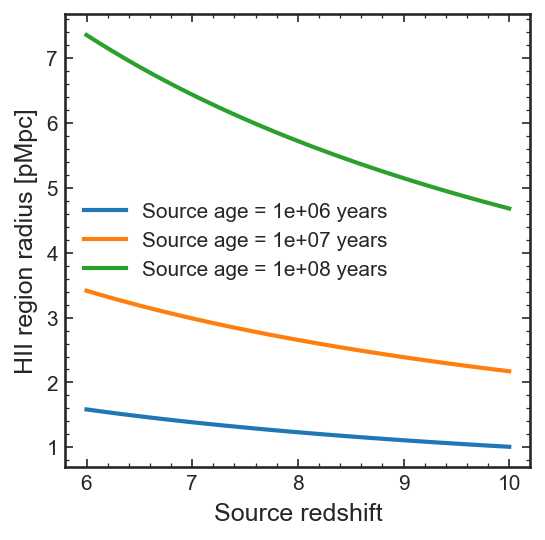

In [95]:
ztab = np.linspace(6., 10)

age_tab = np.logspace(-1, 1, 3)*1e7*u.year

for age in age_tab:
    
    plt.plot(ztab, bubbles.R_bubble_CenHaiman2000(ztab, Ndot_ion=1e57/u.s, 
                                                  t_source=age),
             label='Source age = %.0e years' % age.value)

plt.legend()

plt.xlabel('Source redshift')
plt.ylabel('HII region radius [pMpc]')

plt.savefig('../figs/R_HII_age.pdf')

## Ionized fraction

In [4]:
Rtab = np.logspace(-2., 1.5) * u.Mpc

### As a function of Nion

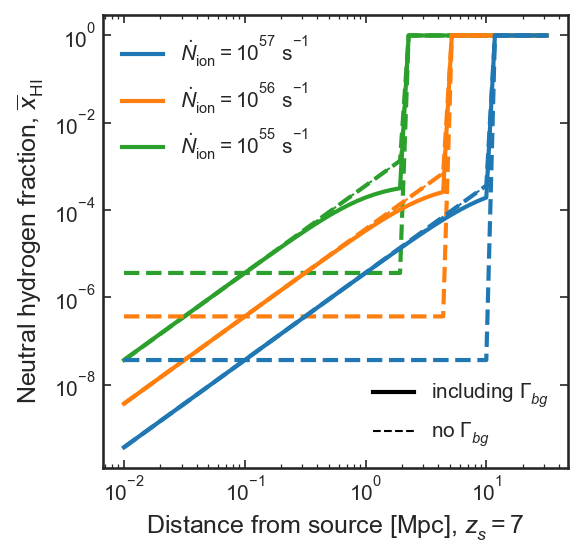

In [8]:
z_s = 7.

fesc_tab = [1, 0.1, 0.01]
for fesc in fesc_tab:
    
    Ndot_ion = bubbles.Ndot_ion_from_Lnu(bubbles.nu_tab, fesc=fesc/2., qso=True)

    R_HII = bubbles.R_bubble_Stromgren(z_s, Ndot_ion=Ndot_ion)
    
    # No background
    xHI_radial = bubbles.xHI_R(r=Rtab, z_s=z_s, fesc=fesc/2., J_bg=None)    
    xHI_radial[Rtab > R_HII] = 1.
    
    ln = plt.loglog(Rtab, xHI_radial, zorder=fesc, lw=1, ls='dashed')

    # With background
    xHI_radial = bubbles.xHI_R(r=Rtab, z_s=z_s, fesc=fesc/2., J_bg=1.)    
    xHI_radial[Rtab > R_HII] = 1.
    
    plt.loglog(Rtab, xHI_radial, zorder=fesc, lw=2, c=ln[0].get_color(),
               label='$\dot{N}_\mathrm{ion} = 10^{%.0f}$ s$^{-1}$' % np.log10(Ndot_ion.value))
    
    xHI_01 = (xHI_radial[np.abs(Rtab.value - 0.1) < 0.005])[0]
    xHI = bubbles.xHI_approx(xHI_01, Rtab, R_HII)
    
    plt.loglog(Rtab, xHI, zorder=fesc, lw=2, ls='dashed', c=ln[0].get_color())
    
    xHI = bubbles.xHI_approx(xHI_01, Rtab, R_HII, r_slope=0.)
    plt.loglog(Rtab, xHI, zorder=fesc, lw=2, ls='dashed', c=ln[0].get_color())
               
background_line   = mlines.Line2D([], [], color='k', lw=2, label='including $\Gamma_{bg}$')
nobackground_line = mlines.Line2D([], [], color='k', lw=1, ls='dashed', label='no $\Gamma_{bg}$')

leg = plt.legend(handles=[background_line, nobackground_line], loc='lower right')
plt.gca().add_artist(leg)

plt.legend()

plt.xlabel('Distance from source [Mpc], $z_s=%.0f$' % z_s)
plt.ylabel('Neutral hydrogen fraction, $\overline{x}_\mathrm{HI}$')

plt.savefig('../figs/x_HI_withbg_zs=%.0f.pdf' % z_s)

### As a function of UV background fluctuation

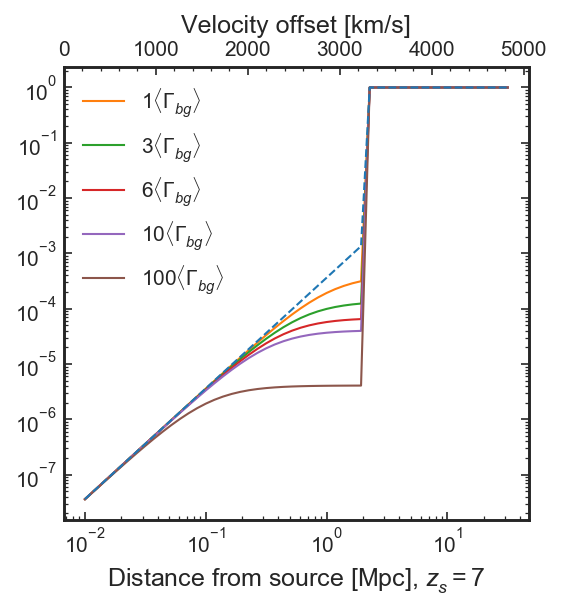

In [38]:
z_s = 7.
fesc = 0.01

Ndot_ion = bubbles.Ndot_ion_from_Lnu(bubbles.nu_tab, fesc=fesc/2., qso=True)

R_HII = bubbles.R_bubble_Stromgren(z_s, Ndot_ion=Ndot_ion)

# No background
xHI_radial = bubbles.xHI_R(r=Rtab, z_s=z_s, fesc=fesc/2., J_bg=None)    
xHI_radial[Rtab > R_HII] = 1.


ax_r  = plt.subplot()
ax_DV = ax_r.twiny()

ax_r.loglog(Rtab, xHI_radial, zorder=fesc, lw=1, ls='dashed')

def Rcom_to_DV(Rcom, z):
    return (Rcom*Planck15.H(z)/(1.+z)).to(u.km/u.s)

# Plot
ax_DV.plot(Rcom_to_DV(Rtab, z=z_s), xHI_radial, lw=0)

J_bg_tab = [1, 3., 6., 10., 100]
for J_bg in J_bg_tab:

    # With background
    xHI_radial = bubbles.xHI_R(r=Rtab, z_s=z_s, fesc=fesc/2., J_bg=J_bg)    
    xHI_radial[Rtab > R_HII] = 1.
    
    ax_r.loglog(Rtab, xHI_radial, zorder=0, lw=1,
               label=r'$%.0f \langle \Gamma_{bg} \rangle$' % J_bg)
    

# Set xlims
# ax_DV.set_xlim(DV_min, DV_max)
ax_DV.set_xlim(Rcom_to_DV(np.array(ax_r.get_xlim())*u.Mpc, z=z_s).value)

ax_DV.set_xlabel('Velocity offset [km/s]')

ax_r.legend()

ax_r.set_xlabel('Distance from source [Mpc], $z_s=%.0f$' % z_s)
plt.ylabel('Neutral hydrogen fraction, $\overline{x}_\mathrm{HI}$')

plt.savefig('../figs/x_HI_change_bg_zs=%.0f.pdf' % z_s)

### As a function of spectral index

1.9935457956050737e+56 1 / s 1.993545795605074e+56 1 / s
1.993545795605074e+56 1 / s 1.993545795605074e+56 1 / s
1.993545795605074e+56 1 / s 1.993545795605074e+56 1 / s


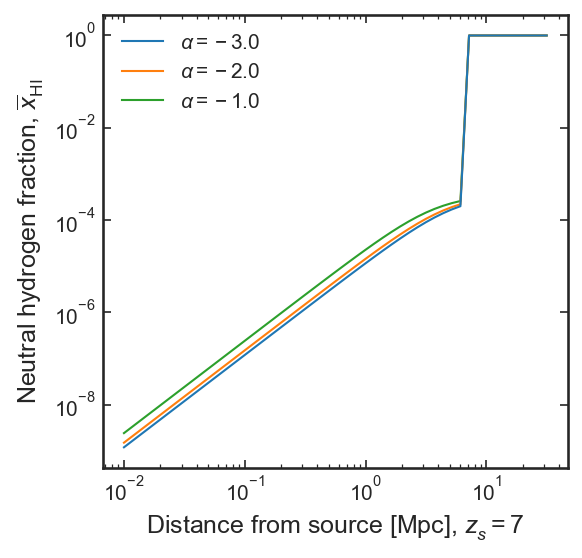

In [17]:
fesc_scale = 0.1
Ndot_ion_18 = bubbles.ionizing_sources.Ndot_ion_from_Lnu(bubbles.nu_tab, fesc=fesc_scale, qso=True, alpha=-1.8)
z_s = 7.

alpha_tab = [-3, -2, -1.]
for alpha in alpha_tab:
    
    Ndot_ion = bubbles.ionizing_sources.Ndot_ion_from_Lnu(bubbles.nu_tab, fesc=fesc_scale, qso=True, alpha=alpha)

    fesc = fesc_scale * Ndot_ion_18/Ndot_ion
    Ndot_ion = bubbles.ionizing_sources.Ndot_ion_from_Lnu(bubbles.nu_tab, fesc=fesc, qso=True, alpha=alpha)
    print(Ndot_ion, Ndot_ion_18)

    R_HII = bubbles.R_bubble_Stromgren(z_s, Ndot_ion=Ndot_ion)
    
    # No background
    xHI_radial = bubbles.xHI_R(r=Rtab, z_s=z_s, fesc=fesc, J_bg=True, alpha=alpha)    
    xHI_radial[Rtab > R_HII] = 1.
    
    ln = plt.loglog(Rtab, xHI_radial, zorder=fesc, lw=1,
                   label=r'$\alpha = %.1f$' % alpha)

plt.legend()

plt.xlabel('Distance from source [Mpc], $z_s=%.0f$' % z_s)
plt.ylabel('Neutral hydrogen fraction, $\overline{x}_\mathrm{HI}$')

plt.savefig('../figs/x_HI_spectralindex.pdf')

### As a function of temperatures

Text(0, 0.5, 'Case B recombination coefficient [cm$^3$ s$^{-1}$]')

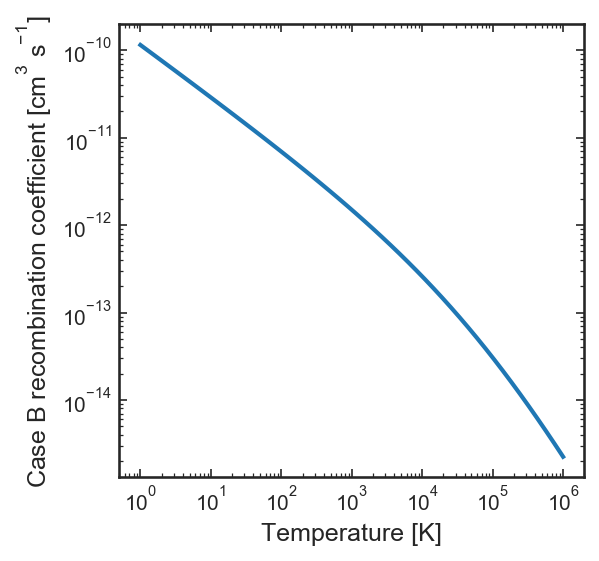

In [129]:
T = np.logspace(0, 6)

plt.loglog(T, bubbles.alpha_rec_B(T))

plt.xlabel('Temperature [K]')
plt.ylabel('Case B recombination coefficient [cm$^3$ s$^{-1}$]')

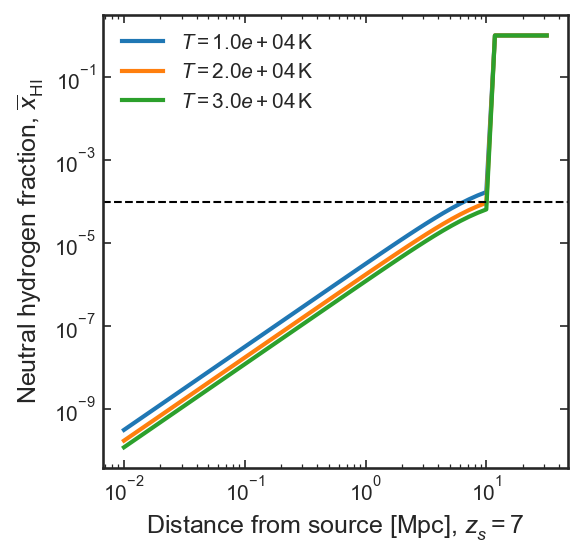

In [134]:
Ndot_ion_18 = bubbles.Ndot_ion_from_Lnu(bubbles.nu_tab, fesc=0.5, qso=True, alpha=-1.8)

z_s = 7.
R_HII = bubbles.R_bubble_Stromgren(z_s, Ndot_ion=Ndot_ion_18)

T_tab = [1e3, 1e4, 1e5, 1e6]
T_tab = [1e4, 2e4, 3e4]
for T in T_tab:
    
    # No background
    xHI_radial = bubbles.xHI_R(r=Rtab, z_s=z_s, fesc=0.5, J_bg=True, T=T)    
    xHI_radial[Rtab > R_HII] = 1.
    
    ln = plt.loglog(Rtab, xHI_radial, lw=2,
                   label=r'$T = %.1e\,$K' % T)

plt.axhline(1e-4, ls='dashed', lw=1, c='k')

plt.legend()

plt.xlabel('Distance from source [Mpc], $z_s=%.0f$' % z_s)
plt.ylabel('Neutral hydrogen fraction, $\overline{x}_\mathrm{HI}$')

plt.savefig('../figs/x_HI_temperature.pdf')

### As a function of redshift

Text(0, 0.5, 'Residual neutral fraction at 0.1 Mpc')

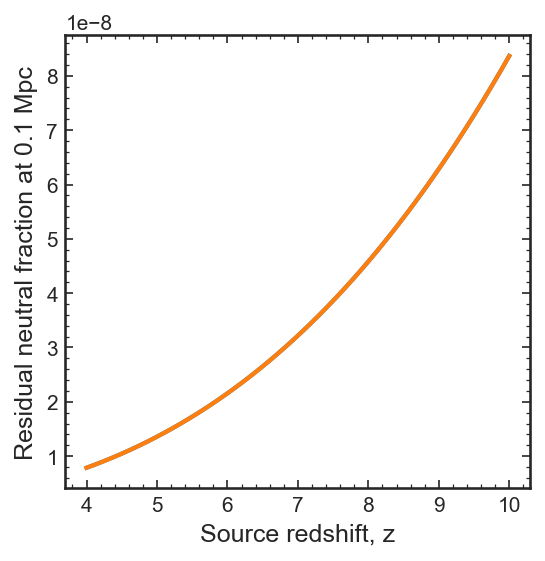

In [20]:
ztab = np.linspace(4., 10.)

fesc     = 1
Ndot_ion = bubbles.Ndot_ion_from_Lnu(bubbles.nu_tab, fesc=fesc/2., qso=True)

R_HII = bubbles.R_bubble_Stromgren(ztab, Ndot_ion=Ndot_ion)
    
# No background
xHI_radial = bubbles.xHI_R(r=0.1*u.Mpc, z_s=ztab, fesc=fesc/2., J_bg=False) 
plt.plot(ztab, xHI_radial)

xHI_radial = bubbles.xHI_R(r=0.1*u.Mpc, z_s=ztab, fesc=fesc/2., J_bg=True) 
plt.plot(ztab, xHI_radial)

plt.xlabel('Source redshift, z')
plt.ylabel('Residual neutral fraction at 0.1 Mpc')

## Ionization front ODE

R is in proper Mpc

$$ \frac{dR^3}{dt} = 3 H(z) R^3 + \frac{3 \dot{N}_{ion}}{4\pi n_H} - C n_H \alpha_B R^3$$

$$ \frac{dR^3}{dz} + \frac{C n_H \alpha_B - 3 H(z)}{(1+z)H(z)} R^3 = \frac{3 \dot{N}_{ion}}{4\pi n_H (1+z)H(z)}$$

$\alpha_B = 2.59\times^{-13}$ cm^3/s (Draine p. 138, table 14.1)


In [4]:
def ionization_front_ionizations(z, Ndot_ion=1.e57/u.s):
    return (0.75 * Ndot_ion / (np.pi * bubbles.n_H(z))).to(u.Mpc**3./u.yr)

def ionization_front_recombinations(z, R=1.*u.Mpc, C=3, a_B=2.59e-13*u.cm**3./u.s):
    return (-a_B * C * bubbles.n_H(z) * R**3.).to(u.Mpc**3./u.yr)

def ionization_front_Hubble(z, R=1.*u.Mpc):
    return (3* Planck15.H(z) * R**3.).to(u.Mpc**3./u.yr)

[428.16596787 411.94013506 396.70885551 382.38929639 368.90723174
 356.19598213 344.19550407 332.85160544 322.11526746 311.94205697
 302.29161552 293.12721401 284.4153634  276.12547363 268.22955387
 260.70194868 253.51910498 246.65936604 240.10278867 233.83098094
 227.8269576  222.07501116 216.56059662 211.27022829 206.19138724
 201.31243807 196.62255407 192.1116497  187.77031961 183.58978353
 179.56183631 175.67880261 171.93349577 168.31918034 164.82953801
 161.45863651 158.20090118 155.05108903 152.00426495 149.05577996
 146.20125117 143.43654345 140.75775252 138.16118944 135.64336625
 133.2009828  130.83091449 128.53020107 126.29603614 124.12575755] Mpc


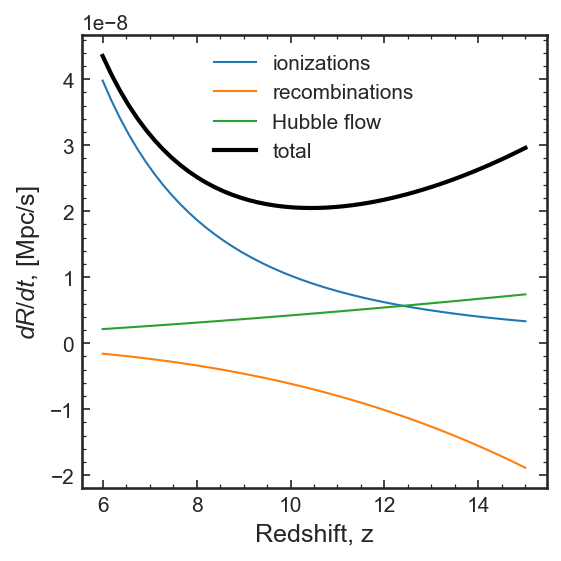

In [5]:
ztab = np.linspace(6, 15.)

horizon = (const.c/Planck15.H(z=ztab)).to(u.Mpc)
print(horizon)

R = 1.*u.Mpc
Ndot_ion = 1.e55/u.s

dRdt_ion = ionization_front_ionizations(ztab, Ndot_ion=Ndot_ion)
dRdt_rec = ionization_front_recombinations(ztab, R=R)
dRdt_Hub = ionization_front_Hubble(ztab, R=R)

plt.plot(ztab, dRdt_ion, lw=1, label='ionizations')
plt.plot(ztab, dRdt_rec, lw=1, label='recombinations')
plt.plot(ztab, dRdt_Hub, lw=1, label='Hubble flow')

plt.plot(ztab, dRdt_ion - dRdt_rec + dRdt_Hub, c='k', label='total')

plt.xlabel('Redshift, z')
plt.ylabel('$dR/dt$, [Mpc/s]')

plt.legend()

### Solve ODE

In [6]:
# Define a function which calculates the derivative
def dR3_dt(t, R3, z_s0=10, Ndot_ion=1.e55/u.s,):
  #         Ndot_ion_type='constant', Ndot_ion_alpha=-2.):
    """
    Rate of growth of R^3 ionization front
    in Mpc/yr
    
    NB: for solve_ivp must be fun(t, y)
    """
    # Age of universe when source turned on
    t_source_on = Planck15.age(z=z_s0)
    
    # At age of source, t, what is redshift?
    t_now = t*u.yr + t_source_on
    try:
        z_tab_sourceage = np.array([z_at_value(Planck15.age, time) for time in t_now])
    except:
        z_tab_sourceage = z_at_value(Planck15.age, t_now)

    R = R3**(1./3.) * u.Mpc
    
#     # Ndot_ion
#     if Ndot_ion
#     Ndot_ion_burst(t, burst_freq=5e7*u.yr, burst_height=1.e57/u.s,
                   
#     print(t, Ndot_ion)           
    # Components of ionization front growth
    # All in Mpc**3/yr
    dR3dt_ion = ionization_front_ionizations(z_s0, Ndot_ion=Ndot_ion).value
    dR3dt_rec = ionization_front_recombinations(z_s0, R=R).value
    dR3dt_Hub = ionization_front_Hubble(z_tab_sourceage, R=R).value
    
    return dR3dt_ion - dR3dt_rec + dR3dt_Hub

In [65]:
%timeit solve_ivp(fun=lambda t, y: dR3_dt(t, y, *args), t_span=[t_tab[0], t_tab[-1]], y0=[0.], t_eval=t_tab, method='RK23', vectorized=True, )
%timeit odeint(dR3_dt, y0=0., t=t_tab, args=(z_s0, Ndot_ion), tfirst=True)

578 ms ± 2.85 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
951 ms ± 46.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


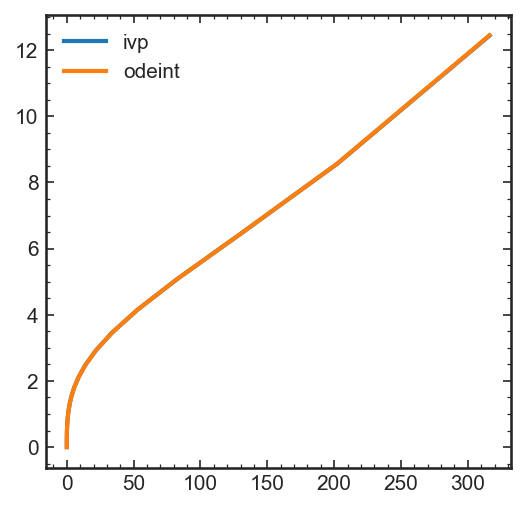

In [7]:
z_s0     = 10
# Redshift source turned on
Ndot_ion = 1e57/u.s
t_tab    = np.logspace(-1, 8.5)
# t_tab = np.linspace(0, 3e8)
args=z_s0, Ndot_ion
sol = solve_ivp(fun=lambda t, y: dR3_dt(t, y, *args), t_span=[t_tab[0], t_tab[-1]], y0=[0.], t_eval=t_tab, 
                method='RK23', vectorized=True, )
R_ivp = sol.y.T**(1/3.)

R3 = odeint(dR3_dt, y0=0., t=t_tab, args=(z_s0, Ndot_ion), tfirst=True)
R_odeint = R3.T[0]**(1/3.)

plt.plot(t_tab/1e6, R_ivp, label='ivp')
plt.plot(t_tab/1e6, R_odeint, label='odeint')
plt.legend()

/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/matplotlib/mathtext.py:827: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


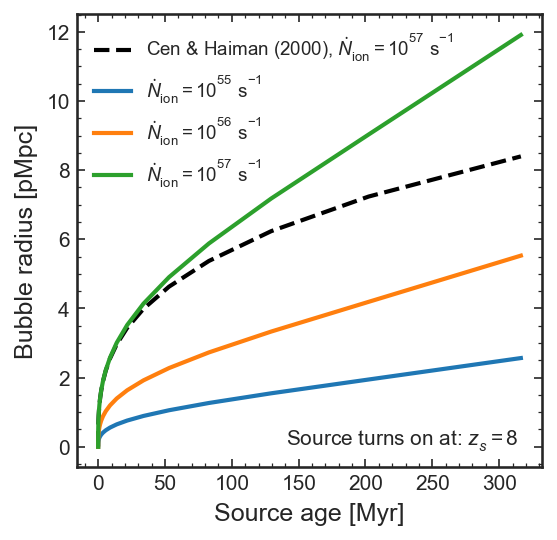

In [8]:
t_tab = np.linspace(0, 3e8)
t_tab = np.logspace(-1, 8.5)

z_s0 = 8 # Redshift source turned on

Ndot_ion_tab = np.logspace(55, 57, 3)/u.s

plt.plot(t_tab/1e6, bubbles.R_bubble_CenHaiman2000(z_s0, Ndot_ion=1.e57/u.s, t_source=t_tab*u.yr), 
         ls='dashed', c='k', label='Cen & Haiman (2000), $\dot{N}_\mathrm{ion} = 10^{57}$ s$^{-1}$')

for Ndot_ion in Ndot_ion_tab:
            
    R3 = odeint(dR3_dt, y0=0., t=t_tab, args=(z_s0, Ndot_ion), tfirst=True)

    R = R3.T[0]**(1/3.)
    
    plt.plot(t_tab/1e6, R, label='$\dot{N}_\mathrm{ion} = 10^{%.0f}$ s$^{-1}$' % np.log10(Ndot_ion.value))
    
#     plt.semilogx(t_tab, R/R_S, label='$\dot{N}_\mathrm{ion} = 10^{%.0f}$ s$^{-1}$' % np.log10(Ndot_ion.value))
    
    
plt.annotate('Source turns on at: $z_s = %.0f$' % z_s0, xy=(0.95, 0.05), xycoords='axes fraction', ha='right')
    
plt.xlabel('Source age [Myr]')
plt.ylabel('Bubble radius [pMpc]')

plt.legend(fontsize=9)

plt.savefig('../figs/R_HII_age_compareCH00.pdf', bbox_inches='tight')

### As a function of source redshift

In [9]:
def R_optically_thin(z, Ndot_ion, alpha_s, reccase='B', 
                     T=1e4*u.K, fesc=0.1, C=3, tau_lim=2.3, J_bg=0):
    """
    Proper radius of Lya optically thin region
    
    aka proximity zone
    """
    
    A = 1.34e-7 * u.cm**3. / u.s
    sigma_ion0 = 6.3e-18 * u.cm**2
    
    if reccase == 'B':
        alpha_rec = bubbles.alpha_rec_B(T.value)
    else:
        alpha_rec = bubbles.alpha_rec_A(T.value)

    gamma_lim = A * C**2. * bubbles.n_H(z)**2. * alpha_rec / Planck15.H(z) / tau_lim
    
    R_alpha2 = fesc/4./np.pi * sigma_ion0 * Ndot_ion * (alpha_s/(alpha_s - 3)) / (gamma_lim - J_bg*bubbles.Gamma12(z)/u.s)
    
    return np.sqrt(R_alpha2).to(u.Mpc)

In [10]:
t_test = 1e8*u.yr
z_now_tab = np.linspace(5, 10) # Redshift source observed

# What redshift did source form?
t_now = Planck15.age(z=z_now_tab)
t_source_on = t_now - t_test
z_source_on = np.array([z_at_value(Planck15.age, time) for time in t_source_on])

Ndot_ion_tab = np.logspace(55, 57, 3)/u.s

R_HII_Ndot_ion = {}
for Ndot_ion in Ndot_ion_tab:

    R3 = np.array([odeint(dR3_dt, y0=0., t=[0, t_test.value], args=(z_0, Ndot_ion), tfirst=True) for z_0 in z_source_on])
    R  = R3.T[0][1]**(1/3.)
    
    R_HII_Ndot_ion[Ndot_ion] = R

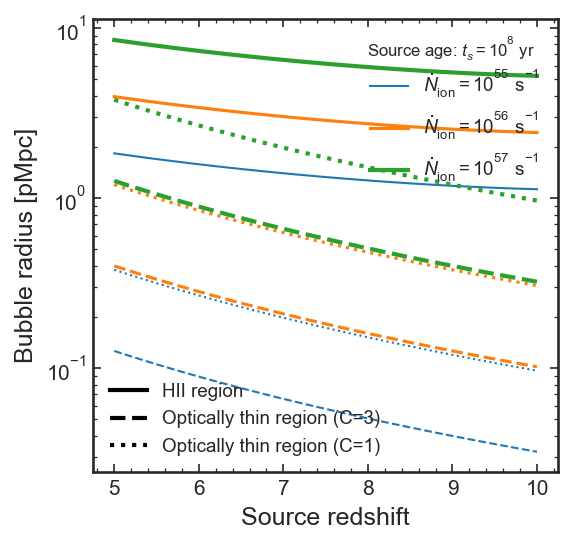

In [11]:
# Cen & Haiman
# R_alpha = R_optically_thin(z=z_now_tab, Ndot_ion=Ndot_ion_tab[-1], 
#                            reccase='B', alpha_s=-1.8, fesc=1, C=1, T=2e4*u.K)    
# ln = plt.plot(z_now_tab, bubbles.R_bubble_CenHaiman2000(z_source_on, Ndot_ion=Ndot_ion_tab[-1], t_source=t_test), 
#          ls='dashed', c='k', label='Cen & Haiman (2000), $\dot{N}_\mathrm{ion} = 10^{57}$ s$^{-1}$')
# plt.plot(z_now_tab, R_alpha, c=ln[0].get_color(), ls='dotted')

for i, Ndot_ion in enumerate(Ndot_ion_tab):
    
    ln = plt.plot(z_now_tab, R_HII_Ndot_ion[Ndot_ion], lw=1+i/2,
                  label='$\dot{N}_\mathrm{ion} = 10^{%.0f}$ s$^{-1}$' % np.log10(Ndot_ion.value))
    
    R_alpha = R_optically_thin(z=z_now_tab, Ndot_ion=Ndot_ion, 
                               reccase='B', alpha_s=-1.8, fesc=1, 
                               C=3, T=1e4*u.K)    
    plt.plot(z_now_tab, R_alpha, ls='dashed', lw=1+i/2, c=ln[0].get_color())

    R_alpha = R_optically_thin(z=z_now_tab, Ndot_ion=Ndot_ion, 
                               reccase='B', alpha_s=-1.8, fesc=1, 
                               C=1, T=1e4*u.K)    
    plt.semilogy(z_now_tab, R_alpha, ls='dotted', lw=1+i/2, c=ln[0].get_color())


plt.annotate('Source age: $t_s = 10^%.0f$ yr' % np.log10(t_test.value), xy=(0.95, 0.92), 
             xycoords='axes fraction', ha='right', fontsize=8)
    
plt.xlabel('Source redshift')
plt.ylabel('Bubble radius [pMpc]')

RHII_line   = mlines.Line2D([], [], color='k', lw=2, label='HII region')
Ralpha_lineC3 = mlines.Line2D([], [], color='k', lw=2, ls='dashed', label='Optically thin region (C=3)')
Ralpha_lineC1 = mlines.Line2D([], [], color='k', lw=2, ls='dotted', label='Optically thin region (C=1)')

leg = plt.legend(handles=[RHII_line, Ralpha_lineC3, Ralpha_lineC1], loc='lower left', fontsize=9)
plt.gca().add_artist(leg)

plt.legend(fontsize=9, loc=(0.58, 0.62))
# plt.ylim(-0.1, 10.1)
# plt.savefig('../figs/RHII_redshift.pdf', bbox_inches='tight')
plt.savefig('../figs/RHII_Ralpha_redshift.pdf', bbox_inches='tight')

### Fluctuating Nion

/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in power


Text(0, 0.5, '$\\dot{N}_\\mathrm{ion}$ [s$^{-1}$]')

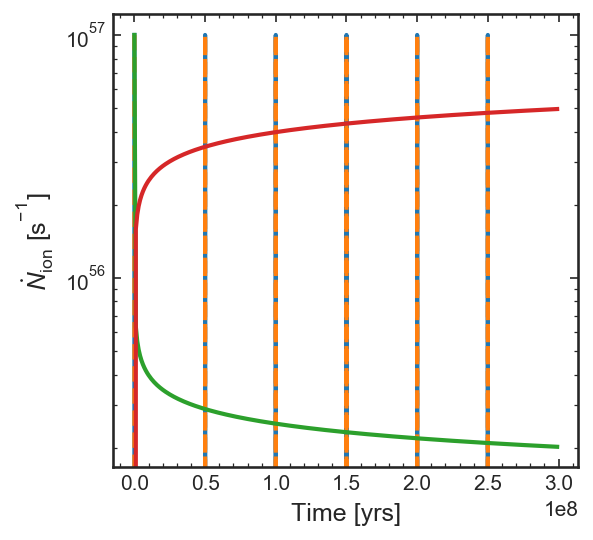

In [222]:
def Ndot_ion_burst(t, burst_freq=5e7*u.yr, burst_height=1.e57, min_diff=1e6):
    """
    Make Ndot_ion equally spaced bursts every burst_freq years
    """
    try: # if array
        bursts = np.arange(0, max(t)+1, burst_freq.value)
        Ndot_ion = np.zeros(len(t))
#         burst_match = [np.abs(burst - t) < min_diff for burst in bursts]
        Ndot_ion[np.in1d(t, bursts)] = burst_height
    except: # float
        bursts = np.arange(0, t+1, burst_freq.value)
#         print(bursts - t)
        if np.any(np.abs(bursts - t) < min_diff):
            Ndot_ion = burst_height
        else:
            Ndot_ion = 0.
        
    return Ndot_ion

def Ndot_ion_powerlaw(t, alpha=-2., Ndot_ion_0=1.e57):
    try:
        if t < 1:
            Ndot_ion = Ndot_ion_0
        else:
            Ndot_ion = Ndot_ion_0 * t**alpha
    except:
        Ndot_ion = Ndot_ion_0 * t**alpha
        Ndot_ion[~np.isfinite(Ndot_ion)] = Ndot_ion_0
    return Ndot_ion

t_tab = np.arange(0., 3e8, 1e6)
# print(Ndot_ion_burst(t_tab))
# t_tab = np.logspace(-1, 8.5, 100)
plt.plot(t_tab, Ndot_ion_burst(t_tab))
plt.plot(t_tab, np.array([Ndot_ion_burst(t) for t in t_tab]), ls='dashed')
plt.semilogy(t_tab, Ndot_ion_powerlaw(t_tab, alpha=-0.2))    
plt.semilogy(t_tab, Ndot_ion_powerlaw(t_tab, alpha=0.2, Ndot_ion_0=1.e55))    

plt.xlabel('Time [yrs]')
plt.ylabel('$\dot{N}_\mathrm{ion}$ [s$^{-1}$]')

In [232]:
z_s0     = 10 # Redshift source turned on
Ndot_ion = 1e57/u.s

t_tab = np.arange(0., 5e8, 1e6)

sol = solve_ivp(fun=lambda t, y: dR3_dt(t, y, z_s0, Ndot_ion), 
                t_span=[t_tab[0], t_tab[-1]], y0=[0.], t_eval=t_tab, 
                method='RK23', vectorized=True, )
R_const = sol.y.T**(1/3.)

sol = solve_ivp(fun=lambda t, y: dR3_dt(t, y, z_s0, Ndot_ion_burst(t, burst_height=1e58)/u.s), 
                t_span=[t_tab[0], t_tab[-1]], y0=[0.], t_eval=t_tab, 
                method='RK23', vectorized=True, )
R_burst = sol.y.T**(1/3.)

sol = solve_ivp(fun=lambda t, y: dR3_dt(t, y, z_s0, Ndot_ion_powerlaw(t, alpha=-0.1)/u.s), 
                t_span=[t_tab[0], t_tab[-1]], y0=[0.], t_eval=t_tab, 
                method='RK23', vectorized=True, )
R_decline = sol.y.T**(1/3.)

sol = solve_ivp(fun=lambda t, y: dR3_dt(t, y, z_s0, Ndot_ion_powerlaw(t, alpha=0.2, Ndot_ion_0=1.e55)/u.s), 
                t_span=[t_tab[0], t_tab[-1]], y0=[0.], t_eval=t_tab, 
                method='RK23', vectorized=True, )
R_increase = sol.y.T**(1/3.)

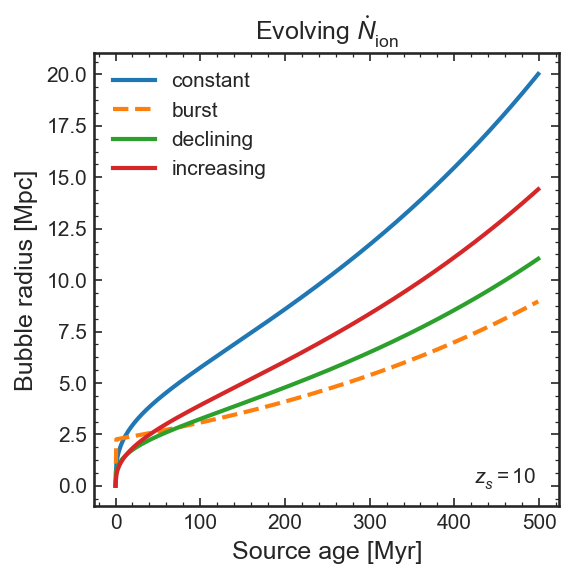

In [234]:
plt.plot(t_tab/1e6, R_const, label='constant')
plt.plot(t_tab/1e6, R_burst, ls='dashed', label='burst')
plt.plot(t_tab/1e6, R_decline, label='declining')
plt.plot(t_tab/1e6, R_increase, label='increasing')

plt.legend()
    
plt.annotate('$z_s = %.0f$' % z_s0, xy=(0.95, 0.05), xycoords='axes fraction', ha='right')

plt.title('Evolving $\dot{N}_\mathrm{ion}$')

plt.xlabel('Source age [Myr]')
plt.ylabel('Bubble radius [Mpc]')


plt.savefig('../figs/R_HII_age_evolving_Nion.pdf', bbox_inches='tight')

# Optical depth

$$ \tau(\lambda_{obs, z_s}) = \int_{z_0}^{z_s} \, dz \; c \frac{dt}{dz} n_H(z) \sigma_\alpha(\lambda_{obs}/(1+z)) $$

Neutral hydrogen density depends on HI fraction, calculate this inside the HII regions:

$$ n_H(z) = n_{H,0}(z) x_{HI}$$

In [4]:
wave_em = np.linspace(1210, 1220., 1000) * u.Angstrom

## Simple case with Stromgren sphere

In [26]:
wave_em = np.linspace(1210, 1220., 1000) * u.Angstrom

z_s   = 7.
z_min = 6.

Ndot_ion = 1.e57/u.s

R_ion = bubbles.R_bubble_CenHaiman2000(z_s, Ndot_ion=Ndot_ion)
z_ion = bubbles.z_at_comoving_distance(R_ion, z_1=z_s)

print(R_ion, z_ion)

# inside bubble
tau_HII = optical_depth(wave_em, z_min=z_ion, z_max=z_s, z_s=z_s,
                        inside_HII=True, T=1.e4*u.K, Ndot_ion=Ndot_ion)

# in IGM
tau_IGM = optical_depth(wave_em, z_min=z_min, z_max=z_ion, z_s=z_s,
                        inside_HII=False, T=1.*u.K, Ndot_ion=Ndot_ion)

3.1130177630958102 Mpc 6.991125391413053


/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/astropy/units/quantity.py:463: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Text(0.5, 0, 'Velocity offset [km/s]')

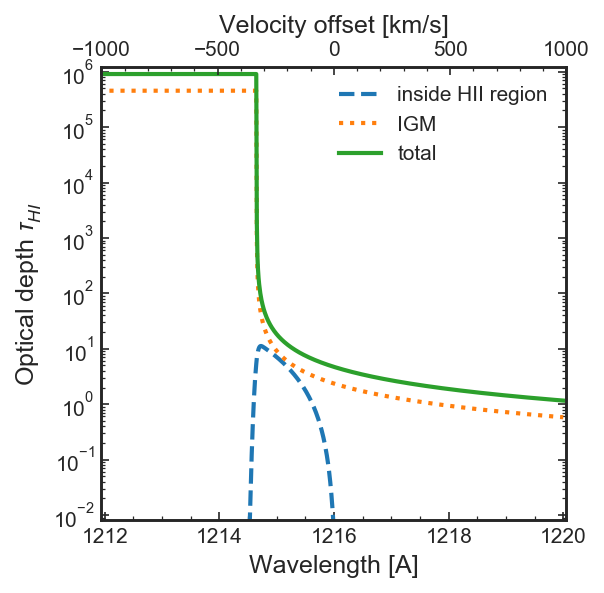

In [29]:
DV_tab = bubbles.wave_to_DV(wave_em)

fig, ax_wave = plt.subplots(1,1)

ax_wave.semilogy(wave_em, tau_HII, ls='dashed', label='inside HII region')
ax_wave.semilogy(wave_em, tau_IGM, ls='dotted', label='IGM')

tau_total = tau_IGM + tau_IGM

ax_wave.semilogy(wave_em, tau_total, label='total')

ax_DV = ax_wave.twiny()
ax_DV.semilogy(DV_tab, tau_total, label='total', lw=0)

ax_wave.legend()
ax_wave.set_ylim(0.8e-2, 1.2e6)
ax_DV.set_xlim(-1000, 1000)
ax_wave.set_xlim(bubbles.DV_to_wave(np.array(ax_DV.get_xlim())*u.km/u.s).value)

ax_wave.set_ylabel(r'Optical depth $\tau_{HI}$')
ax_wave.set_xlabel('Wavelength [A]')
ax_DV.set_xlabel('Velocity offset [km/s]')

## Cen & Haiman

Agrees with Haiman 2002, Cen & Haiman 2000

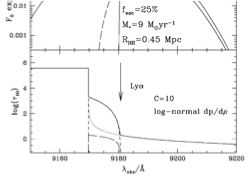

- fesc = 0.25
- SFR = 9 Msun/yr --> Nion = 1.4e54 s-1
- tage = 10^8 yr
- [yes] R_HII = 0.45 pMpc

In [9]:
# Haiman 2002
fesc     = 0.25
Ndot_ion = fesc*1.4e54/u.s 
tage     = 1e8*u.year
C   = 10
z_s = 6.55 #56

# Cen & Haiman 2000
Ndot_ion = 2e57/u.s 
tage     = 1e7*u.year
C   = 3
z_s = 7.

# R_ion is PROPER distance
R_ion = bubbles.R_bubble_CenHaiman2000(z_s=z_s, Ndot_ion=Ndot_ion, t_source=tage)
z_ion = bubbles.z_at_proper_distance(R_ion, z_1=z_s)
z_min = 6.
print(R_ion, z_ion)

wave_em = np.linspace(1200, 1240., 2000) * u.Angstrom

# inside bubble
tau_HII = bubbles.optical_depth(wave_em, z_min=z_ion, z_max=z_s, z_s=z_s,
                                inside_HII=True, C_HII=C, T=1.e4*u.K, Ndot_ion=Ndot_ion)

# in IGM
tau_IGM = bubbles.optical_depth(wave_em, z_min=z_min, z_max=z_ion, z_s=z_s,
                                inside_HII=False, T=1.*u.K, Ndot_ion=Ndot_ion)

tau_total = tau_IGM + tau_HII

3.7639880889263093 Mpc 6.914156812309531


/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/astropy/units/quantity.py:463: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


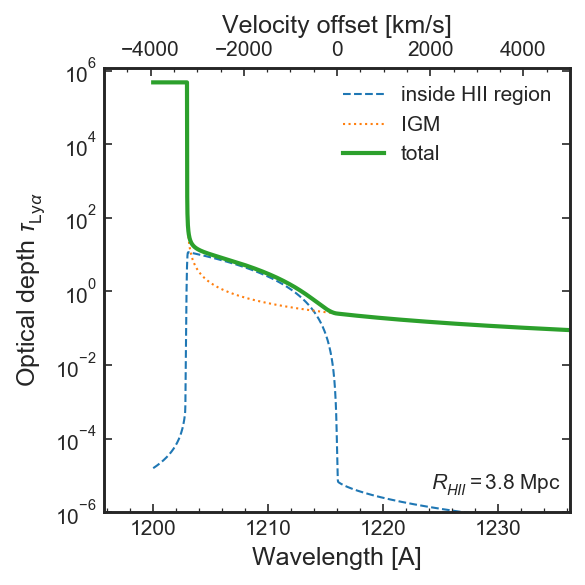

In [10]:
tau_tab = tau_HII, tau_IGM, tau_total

bubbles.plot_tau(tau_tab, wave_em, R_ion, vlim=5000, transmission=False)
# bubbles.plot_tau(tau_tab, wave_em, R_ion, transmission=True)

### Function of temperature

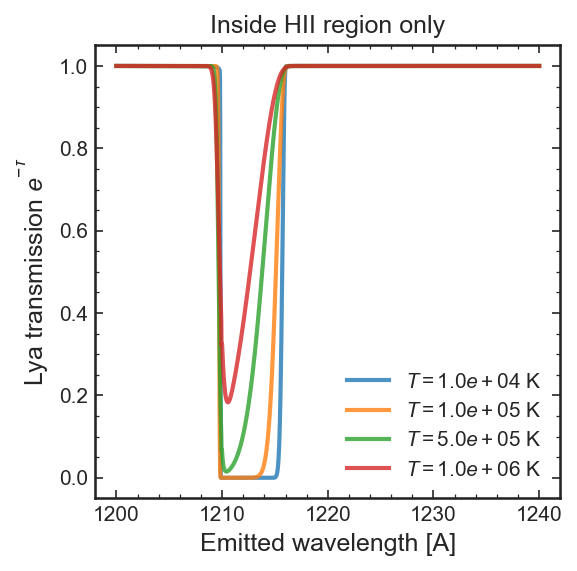

In [72]:
Ndot_ion = 2.e55/u.s 

z_s = 7.

R_ion = bubbles.R_bubble_CenHaiman2000(z_s=z_s, Ndot_ion=Ndot_ion, t_source=1e8*u.year)
z_ion = bubbles.z_at_proper_distance(R_ion, z_1=z_s)
z_min = 6.

T_tab = [1e4, 1e5, 5e5, 1e6]

for T in T_tab:
    tau_HII_T = bubbles.optical_depth(wave_em, z_min=z_ion, z_max=z_s, z_s=z_s,
                                      inside_HII=True, T=T*u.K, Ndot_ion=Ndot_ion)
    
#     plt.semilogy(wave_em, (tau_HII_T), label='$T=%.1e$ K' % T)
    plt.plot(wave_em, np.exp(-tau_HII_T), label='$T=%.1e$ K' % T, alpha=0.8)

plt.xlabel('Emitted wavelength [A]')
# plt.ylabel(r'Lya optical depth $\tau$')
plt.ylabel(r'Lya transmission $e^{-\tau}$')

plt.title('Inside HII region only')

plt.legend()

### Make animation

#### Update Nion

/anaconda2/envs/astroconda3/lib/python3.7/site-packages/astropy/units/quantity.py:463: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


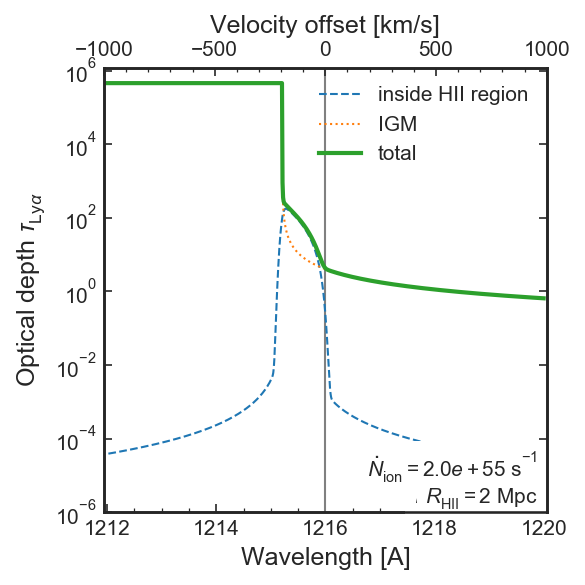

In [576]:
transmission = True
Ndot_ion_tab = np.logspace(-2, 1, 10)*2e57/u.s

fig, ax_wave = plt.subplots(1,1)

ax_wave.axvline(1216., lw=1, c='0.5')

def update_tau_Nion(i):
    # Get new tau and R_ion
    tau_tab, R_ion = make_tau(Ndot_ion=Ndot_ion_tab[i], source_age=1e8*u.year, z_s=7., z_min=6.)
    
    # Plot
    for tt, t in enumerate(tau_tab):
        if transmission:
            ax_wave.lines[tt+1].set_ydata(np.exp(-t))
        else:
            ax_wave.lines[tt+1].set_ydata(t)
            
    # Annotate
    ax_wave.annotate(r'$\dot{N}_\mathrm{ion}=%.1e$ s$^{-1}$' % Ndot_ion_tab[i].value, xy=(0.98, 0.08), 
                     xycoords='axes fraction', ha='right', backgroundcolor='w')
    ax_wave.annotate(r'$R_\mathrm{HII}=%.0f$ Mpc' % np.round(R_ion.value, 0), xy=(0.98, 0.02), 
                     xycoords='axes fraction', ha='right', backgroundcolor='w')
    
# First one
tau_tab, R_ion = make_tau(Ndot_ion=Ndot_ion_tab[0], source_age=1e7*u.year, z_s=7., z_min=6.)
plot_tau(tau_tab, wave_em, R_ion, transmission=transmission, ax=ax_wave, annotate=False)

# Animate
anim_tau = FuncAnimation(fig, update_tau, frames=np.arange(len(Ndot_ion_tab)), interval=600) # interval in ms

if transmission:
    plotname = '../figs/transmission_animate_Nion.gif'
else:
    plotname = '../figs/optdepth_animate_Nion.gif'

anim_tau.save(plotname, dpi=150, writer='imagemagick')

#### Update age

[1.00000000e+06 1.66810054e+06 2.78255940e+06 4.64158883e+06
 7.74263683e+06 1.29154967e+07 2.15443469e+07 3.59381366e+07
 5.99484250e+07 1.00000000e+08] yr


/anaconda2/envs/astroconda3/lib/python3.7/site-packages/astropy/units/quantity.py:463: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


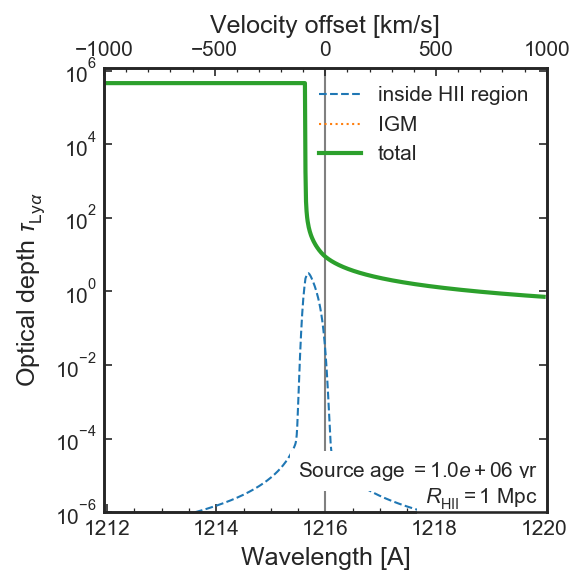

In [167]:
transmission = False
source_age_tab = np.logspace(-2, 0, 10)*1e8*u.year
print(source_age_tab)

fig, ax_wave = plt.subplots(1,1)

ax_wave.axvline(1216., lw=1, c='0.5')

def update_tau_age(i):
    # Get new tau and R_ion
    tau_tab, R_ion = make_tau(Ndot_ion=2e56/u.s, source_age=source_age_tab[i], z_s=7., z_min=6.)
    
    # Plot
    for tt, t in enumerate(tau_tab):
        if transmission:
            ax_wave.lines[tt+1].set_ydata(np.exp(-t))
        else:
            ax_wave.lines[tt+1].set_ydata(t)
            
    # Annotate
    ax_wave.annotate(r'Source age $=%.1e$ yr' % source_age_tab[i].value, xy=(0.98, 0.08), 
                     xycoords='axes fraction', ha='right', backgroundcolor='w')
    ax_wave.annotate(r'$R_\mathrm{HII}=%.0f$ Mpc' % np.round(R_ion.value, 0), xy=(0.98, 0.02), 
                     xycoords='axes fraction', ha='right', backgroundcolor='w')
    
# First one
tau_tab, R_ion = make_tau(Ndot_ion=2e56/u.s, source_age=source_age_tab[0], z_s=7., z_min=6.)
plot_tau_all(tau_tab, wave_em, R_ion, transmission=transmission, ax=ax_wave, annotate=False)

# Animate
anim_tau = FuncAnimation(fig, update_tau_age, frames=np.arange(len(source_age_tab)), interval=600) # interval in ms

if transmission:
    plotname = '../figs/transmission_animate_age.gif'
else:
    plotname = '../figs/optdepth_animate_age.gif'

anim_tau.save(plotname, dpi=150, writer='imagemagick')

# Optical depth on a grid of Nion

## Make a grid

In [11]:
z_s   = 7.
z_min = 6.
source_age = 1e7*u.year
wave_em = np.linspace(1200, 1240., 2000) * u.Angstrom

Ndot_ion_tab = np.logspace(-4, 1, 10)*1e57/u.s
  
tau_tot_tab = []
R_ion_tab   = []
for Ndot_ion in Ndot_ion_tab:
    tau_tab, R_ion = bubbles.make_tau(Ndot_ion=Ndot_ion, source_age=source_age, 
                                      wave_em=wave_em, z_s=z_s, z_min=z_min)
    print(Ndot_ion, R_ion)
    tau_HII, tau_IGM, tau_total = tau_tab

    R_ion_tab.append(R_ion.value)
    tau_tot_tab.append(tau_total)
    
tau_tot_tab = np.array(tau_tot_tab)
R_ion_tab   = np.array(R_ion_tab)

1e+53 1 / s 0.13866650680111756 Mpc
3.593813663804626e+53 1 / s 0.2124010994274914 Mpc
1.291549665014884e+54 1 / s 0.3253433585278974 Mpc
4.641588833612783e+54 1 / s 0.4983415868539137 Mpc
1.6681005372000593e+55 1 / s 0.763329973329644 Mpc
5.994842503189409e+55 1 / s 1.1692234073056451 Mpc
2.1544346900318845e+56 1 / s 1.7909468040776753 Mpc
7.742636826811278e+56 1 / s 2.743265688143697 Mpc
2.782559402207126e+57 1 / s 4.201971057215231 Mpc
1.0000000000000001e+58 1 / s 6.436329095641577 Mpc


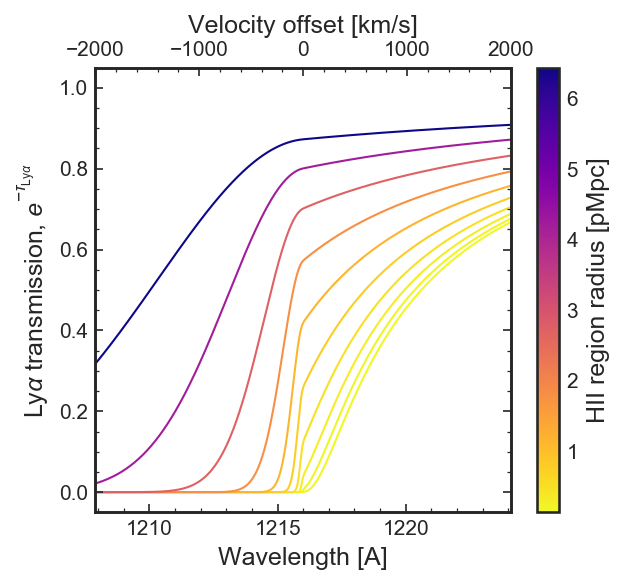

In [12]:
# Plot
s_m = bubbles.scalar_mappable(R_ion_tab, cmap='plasma_r')

DV_tab = bubbles.wave_to_DV(wave_em)

fig, ax_wave = plt.subplots(1,1, figsize=(4.3,4))
ax_DV = ax_wave.twiny()
    
for i, R_ion in enumerate(R_ion_tab):
#     if i % 4 == 0:
        ax_wave.plot(wave_em, np.exp(-tau_tot_tab[i]), c=s_m.to_rgba(R_ion), lw=1, alpha=1, zorder=0)
        ax_DV.plot(DV_tab, np.exp(-tau_tot_tab[i]), lw=0)

plt.colorbar(s_m, label='HII region radius [pMpc]')

plt.yscale('linear')
ax_wave.set_ylim(-0.05, 1.05)
ax_DV.set_xlim(-2000, 2000)
ax_wave.set_xlim(bubbles.DV_to_wave(np.array(ax_DV.get_xlim())*u.km/u.s).value)

ax_wave.set_ylabel(r'Ly$\alpha$ transmission, $e^{-\tau_{\mathrm{Ly}\alpha}}$')
ax_wave.set_xlabel('Wavelength [A]')
ax_DV.set_xlabel('Velocity offset [km/s]')

plt.tight_layout()
plt.savefig('../figs/transmission_R_HII.pdf')

## Video of grid

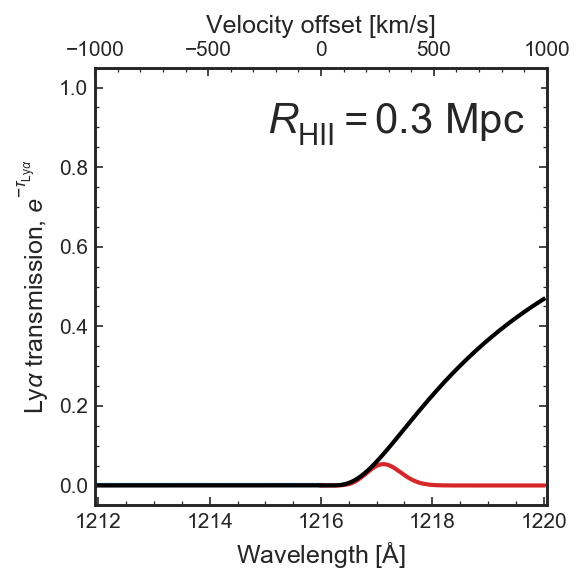

In [30]:
DV_tab = bubbles.wave_to_DV(wave_em)

fig, ax_wave = plt.subplots(1,1, figsize=(4,4))
ax_DV = ax_wave.twiny()

plt.yscale('linear')
ax_wave.set_ylim(-0.05, 1.05)
ax_DV.set_xlim(-1000, 1000)
ax_wave.set_xlim(bubbles.DV_to_wave(np.array(ax_DV.get_xlim())*u.km/u.s).value)

ax_wave.set_ylabel(r'Ly$\alpha$ transmission, $e^{-\tau_{\mathrm{Ly}\alpha}}$')
ax_wave.set_xlabel('Wavelength [$\mathrm{\AA}$]')
ax_DV.set_xlabel('Velocity offset [km/s]')

def update_tau_R(i):
    # Get new tau and R_ion    
    # Plot
    ax_DV.lines[0].set_ydata(np.exp(-tau_tot_tab[i]))
    ax_DV.lines[1].set_ydata((np.exp(-tau_tot_tab[i])*400*lines[10])[velocity < 0.])
    ax_DV.lines[2].set_ydata((np.exp(-tau_tot_tab[i])*400*lines[10])[velocity >= 0.])
            
    # Annotate
    ax_wave.annotate(r'$R_\mathrm{HII}=%.1f$ Mpc' % np.round(R_ion_tab[i], 1), xy=(0.95, 0.85), 
                     xycoords='axes fraction', ha='right', backgroundcolor='w', fontsize=20)
    
# First one
ax_wave.plot(wave_em, np.exp(-tau_tot_tab[0]), lw=0, c='k')
ax_DV.plot(DV_tab, np.exp(-tau_tot_tab[0]), lw=2, c='k')
ax_DV.plot(velocity[velocity < 0.],  (np.exp(-tau_tot_tab[0])*400*lines[10])[velocity < 0.],  c='tab:blue', zorder=0)
ax_DV.plot(velocity[velocity >= 0.], (np.exp(-tau_tot_tab[0])*400*lines[10])[velocity >= 0.], c='tab:red', zorder=0)

# ax_DV.plot(velocity[velocity < 0.],  400*lines[10][velocity < 0.],  c='tab:blue', zorder=0)
# ax_DV.plot(velocity[velocity >= 0.], 400*lines[10][velocity >= 0.], c='tab:red', zorder=0)


# Animate
anim_tau = FuncAnimation(fig, update_tau_R, frames=np.arange(len(R_ion_tab)), 
                         interval=200) # interval in ms

plotname = '../figs/transmission_animate_Rion_linear.gif'

plt.tight_layout()

# plt.savefig(plotname.replace('.gif','_lines.pdf'))
anim_tau.save(plotname, dpi=150, writer='imagemagick')

# Make grid of R_HII, xHI(0.1 Mpc)

Run using scripts/make_tau_grid.py

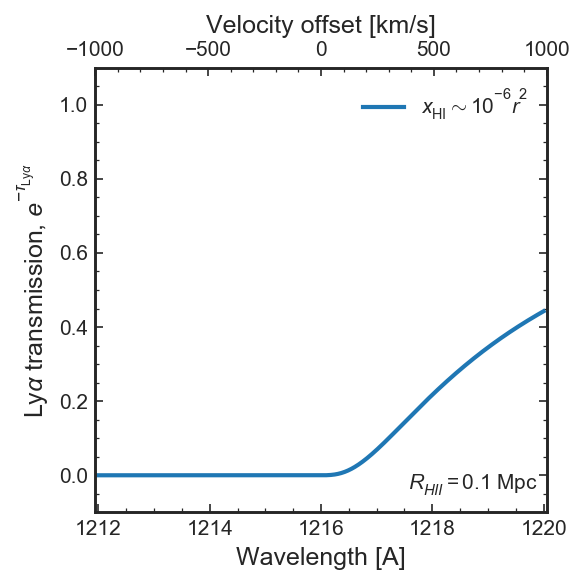

In [72]:
R_ion  = 0.1 * u.Mpc
xHI_01 = 1e-6
trans  = True

fig, ax = plt.subplots(1,1)

tau_tab = bubbles.make_tau_grid(R_ion=R_ion, xHI_01=xHI_01, r_slope=2.)
bubbles.plot_tau(tau_tab[2], bubbles.wave_em, ax=ax, transmission=trans, 
                label=r'$x_\mathrm{HI} \sim 10^{%.0f} r^2$' % np.log10(xHI_01), R_ion=R_ion)

# tau_tab = bubbles.make_tau_grid(R_ion=0.8*u.Mpc, xHI_01=xHI_01, r_slope=2.)
# bubbles.plot_tau(tau_tab[0], bubbles.wave_em, ax=ax, transmission=trans, 
#                 label=r'$x_\mathrm{HI} \sim 10^{%.0f} r^2$' % np.log10(xHI_01), R_ion=R_ion)

# tau_tab = bubbles.make_tau_grid(R_ion=1.2*u.Mpc, xHI_01=xHI_01, r_slope=2.)
# bubbles.plot_tau(tau_tab[0], bubbles.wave_em, ax=ax, transmission=trans, 
#                 label=r'$x_\mathrm{HI} \sim 10^{%.0f} r^2$' % np.log10(xHI_01), R_ion=R_ion)


# tau_tab = bubbles.make_tau_grid(R_ion=R_ion, xHI_01=xHI_01, r_slope=0.)
# bubbles.plot_tau(tau_tab[0], bubbles.wave_em, ax=ax, R_ion=R_ion, 
#                  transmission=trans, label='$x_\mathrm{HI} \sim$ const')

## Load dictionary

In [110]:
def load_dict(r_slope=2., z_s=7., z_min=6.):

    fname_dict = '../data/tau_total_dict_RHII_xHI_grid_zs=%.1f_zmin=%.1f_r=%.0f.pickle' % (z_s, z_min, r_slope)
    with open(fname_dict, 'rb') as fp:
        tau_total_dict = pickle.load(fp)

    keys = np.array([[key[0],key[1]] for key in (tau_total_dict.keys())])

    R_ion_tab  = np.unique(keys[:,0])
    xHI_01_tab = np.unique(keys[:,1])

    print(R_ion_tab)
    print(xHI_01_tab)
    
    return tau_total_dict, R_ion_tab, xHI_01_tab

[0.01 0.11 0.21 0.31 0.41 0.51 0.61 0.71 0.81 0.91 1.01 1.11 1.21 1.31
 1.41 1.51 1.61 1.71 1.81 1.91 2.01 2.11 2.21 2.31 2.41 2.51 2.61 2.71
 2.81 2.91 3.01 3.11 3.21 3.31 3.41 3.51 3.61 3.71 3.81 3.91 4.01 4.11
 4.21 4.31 4.41 4.51 4.61 4.71 4.81 4.91 5.01]
[-9.  -8.5 -8.  -7.5 -7.  -6.5 -6.  -5.5 -5.  -4.5 -4.  -3.5 -3.  -2.5
 -2.  -1.5 -1.  -0.5  0. ]


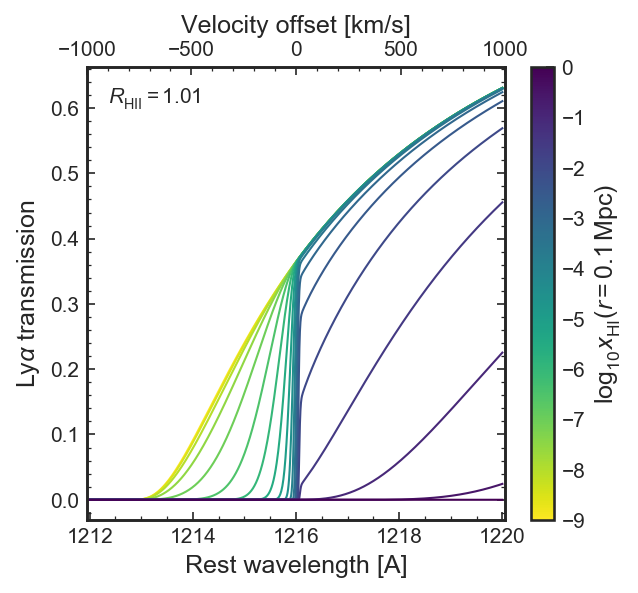

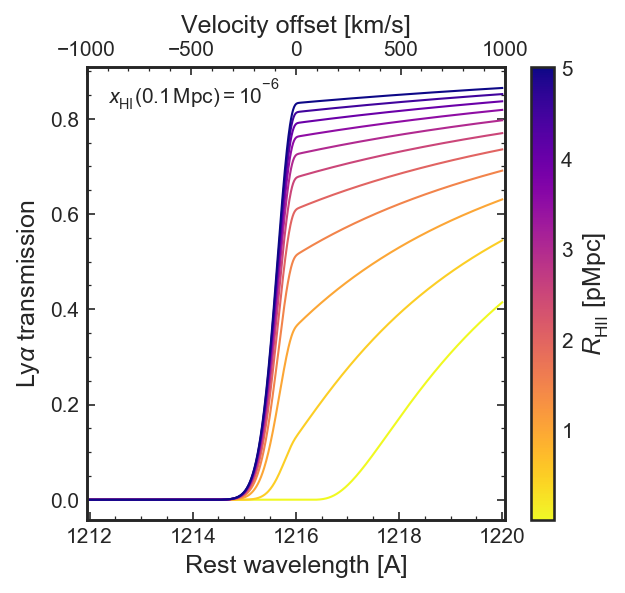

In [111]:
tau_total_dict, R_ion_tab, xHI_01_tab = load_dict(r_slope=2., z_s=7., z_min=6.)

# Change xHI
s_m = bubbles.scalar_mappable(xHI_01_tab, cmap='viridis_r')

plt.figure(figsize=(4.5,4))
ax_wave = plt.subplot()

R_ion_key  = 1.01
for xHI_01 in xHI_01_tab:    
    plt.plot(bubbles.wave_em, np.exp(-tau_total_dict[(R_ion_key, xHI_01)]), 
             c=s_m.to_rgba(xHI_01), alpha=1, lw=1)

# DV axes
ax_DV = bubbles.make_DV_axes(ax_wave, bubbles.wave_em, np.exp(-tau_total_dict[(R_ion_key, xHI_01)]))

plt.annotate('$R_\mathrm{HII} = $%s' % R_ion_key, xy=(0.05,0.92), xycoords='axes fraction')
plt.colorbar(s_m, label='$\log_{10} x_\mathrm{HI} (r=0.1\,$Mpc$)$')

ax_wave.set_xlabel('Rest wavelength [A]')
ax_wave.set_ylabel(r'Ly$\alpha$ transmission')

figname_transmission = '../figs/transmission_grid/transmission_xHI_change_zs=%.1f_zmin=%.1f_r=%.0f.pdf' % (z_s, z_min, r_slope)
plt.savefig(figname_transmission, bbox_inches='tight')

#============================================
# Change R_HII
s_m = bubbles.scalar_mappable(R_ion_tab, cmap='plasma_r')

plt.figure(figsize=(4.5,4))
ax_wave = plt.subplot()
DV = bubbles.wave_to_DV(bubbles.wave_em)
xHI_01_key  = -6.0
for R_ion in R_ion_tab[::5]:   
    plt.plot(bubbles.wave_em, np.exp(-tau_total_dict[(R_ion, xHI_01_key)]), 
             c=s_m.to_rgba(R_ion), alpha=1, lw=1)
    
#     plt.plot(bubbles.wave_em[DV >= 0.], np.exp(-tau_damp_MR06(DV[DV >= 0.], z=z_s, Rb=R_ion*u.Mpc)),
#              ls='dashed', c=s_m.to_rgba(R_ion), alpha=1, lw=1)
    
# DV axes
ax_DV = bubbles.make_DV_axes(ax_wave, bubbles.wave_em, np.exp(-tau_total_dict[(R_ion, xHI_01_key)]))

plt.annotate('$x_\mathrm{HI}(0.1\,$Mpc$) = 10^{%.0f}$' % xHI_01_key, xy=(0.05,0.92), xycoords='axes fraction')
plt.colorbar(s_m, label='$R_\mathrm{HII}$ [pMpc]')

ax_wave.set_xlabel('Rest wavelength [A]')
ax_wave.set_ylabel(r'Ly$\alpha$ transmission')

plt.savefig(figname_transmission.replace('xHI_change','RHII_change'), bbox_inches='tight')

# Add fake lines

-1479.2391019736842 986.1594013157894


Text(0, 0.5, 'Normalized Lya flux')

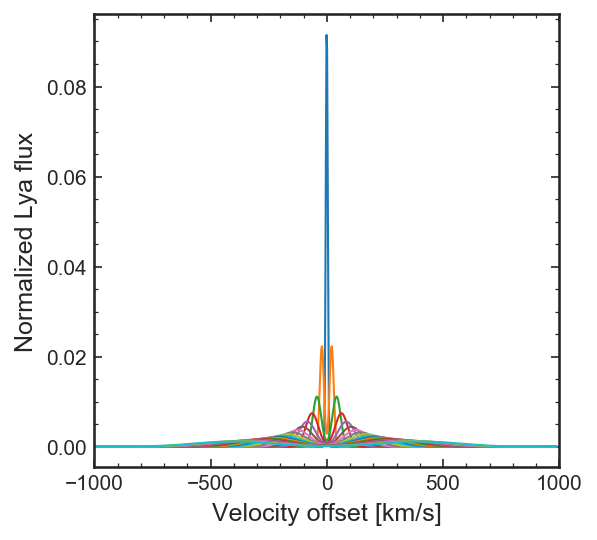

In [88]:
line_DV = np.linspace(-500., 500, 20)
line_DV = np.linspace(0., 400, 20)

velocity = bubbles.wave_to_DV(bubbles.wave_em).value

# lines = np.array([reionizer.line_shape_gauss(v=velocity, vcenter=DV, fwhm=DV, vmin=-2000.) for DV in line_DV])
lines = np.array([bubbles.lineshape_doublepeak(v=velocity, vcenter=DV) for DV in line_DV])

plt.plot(velocity, lines.T, lw=1)
print(velocity.min(), velocity.max())
plt.xlim(-1000, 1000)

plt.xlabel('Velocity offset [km/s]')
plt.ylabel('Normalized Lya flux')

# Grid of R_HII, xHI(0.1 Mpc) transmissions

What is minimum DV observable given R_HII and xHI?

In [113]:
def get_transminDV_DVtrans(tau_tot_dict, T_min=0.1):
    
    where_blue = np.where((velocity < 0.) & (velocity > -1000.))
    where_red  = np.where((velocity > 0.) & (velocity < 1000.))

    trans_minDV_dict = {}  # minimum transmitted DV
    trans_DV_dict = {}     # transmission as a function of DV
    for keys in tau_total_dict.keys():

        trans_tot_tab = np.exp(-tau_total_dict[keys])

        trans_DV = [] 
        DV_list  = []
        DV_trans = []
        for i, line in enumerate(lines):

            transmitted_line = line*trans_tot_tab.T

            Tigm_tot_grid  = np.trapz(transmitted_line, velocity)
            Tigm_blue_grid = 2*np.trapz(transmitted_line[where_blue], velocity[where_blue])
            Tigm_red_grid  = 2*np.trapz(transmitted_line[where_red], velocity[where_red])

            trans_DV.append(Tigm_blue_grid)
            trans_DV.append(Tigm_red_grid)
            DV_list.append(-line_DV[i])
            DV_list.append(line_DV[i]) 

            if Tigm_blue_grid > T_min:
                DV_trans.append(-line_DV[i])
            elif Tigm_red_grid > T_min:
                DV_trans.append(line_DV[i])

        DV_list = np.array(DV_list)
        trans_DV = np.array(trans_DV)
        DV_list_sort_i = np.argsort(DV_list)

        DV_list  = DV_list[DV_list_sort_i]
        trans_DV = trans_DV[DV_list_sort_i]

        trans_DV_dict[keys] = np.array([DV_list, trans_DV]).T

        DV_trans = np.array(DV_trans)

        try:
            trans_minDV_dict[keys] = np.min(DV_trans)
        except:
            trans_minDV_dict[keys] = np.nan
            
    return trans_minDV_dict, trans_DV_dict

## What is minimum DV observable given R_HII and xHI?

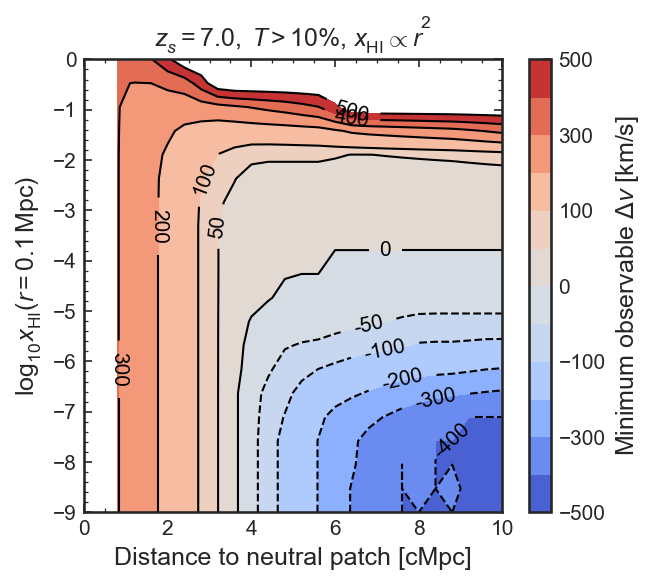

In [90]:
trans_minDV_im = bubbles.dict_to_image(trans_minDV_dict, x=R_ion_tab, y=xHI_01_tab)

# Interpolate
trans_minDV_im[np.isnan(trans_minDV_im)] = 600.
trans_minDV_im_interp = scipy.interpolate.interp2d(R_ion_tab, xHI_01_tab, trans_minDV_im, 
                                                   kind='linear', fill_value=500.)

R_ion_tab_better = np.arange(0.1, 1.5, 0.05)
log10_xHI_01_tab_better = np.linspace(-9,0,20)

trans_minDV_im_interp_better = trans_minDV_im_interp(R_ion_tab_better, log10_xHI_01_tab_better)
trans_minDV_im_interp_better[np.isnan(trans_minDV_im_interp_better)] = 300.

#------------------------------------------------------------
# Plot
plt.figure(figsize=(4.5, 4))

trans_minDV_levels = [-500, -400, -300, -200, -100, -50, 0., 50, 100, 200, 300, 400, 500]

cs = plt.contourf(R_ion_tab_better*(1+z_s), log10_xHI_01_tab_better, trans_minDV_im_interp_better, 
                 levels=trans_minDV_levels, cmap='coolwarm')

plt.colorbar(label=r'Minimum observable $\Delta v$ [km/s]')

cs = plt.contour(R_ion_tab_better*(1+z_s), log10_xHI_01_tab_better, trans_minDV_im_interp_better, 
                 levels=trans_minDV_levels, linewidths=1, colors='k')

plt.xlim(0., 10.)

plt.clabel(cs, cs.levels, fmt='%.0f', inline_spacing=10.)

plt.xlabel('Distance to neutral patch [cMpc]')
if r_slope == 0:
    plt.ylabel('$\log_{10} x_\mathrm{HI}$')
    title = '$z_s = %.1f,\; T > %.0f \%%$, constant $x_\mathrm{HI}$' % (z_s, T_min*100)
else:
    plt.ylabel('$\log_{10} x_\mathrm{HI} (r=0.1\,$Mpc$)$')
    title = '$z_s = %.1f,\; T > %.0f \%%$, $x_\mathrm{HI} \propto r^2$' % (z_s, T_min*100)

plt.title(title)
plt.savefig('../figs/transmission_grid/minimum_observable_DV_zs=%.1f_zmin=%.1f_r=%.0f_T>%.2f.pdf' % (z_s, z_min, r_slope, T_min), bbox_inches='tight')

## Can we tell the difference between constant and r^2 bubbles?

[0.01 0.11 0.21 0.31 0.41 0.51 0.61 0.71 0.81 0.91 1.01 1.11 1.21 1.31
 1.41 1.51 1.61 1.71 1.81 1.91 2.01 2.11 2.21 2.31 2.41 2.51 2.61 2.71
 2.81 2.91 3.01 3.11 3.21 3.31 3.41 3.51 3.61 3.71 3.81 3.91 4.01 4.11
 4.21 4.31 4.41 4.51 4.61 4.71 4.81 4.91 5.01]
[-9.  -8.5 -8.  -7.5 -7.  -6.5 -6.  -5.5 -5.  -4.5 -4.  -3.5 -3.  -2.5
 -2.  -1.5 -1.  -0.5  0. ]
[0.01 0.11 0.21 0.31 0.41 0.51 0.61 0.71 0.81 0.91 1.01 1.11 1.21 1.31
 1.41 1.51 1.61 1.71 1.81 1.91 2.01 2.11 2.21 2.31 2.41 2.51 2.61 2.71
 2.81 2.91 3.01 3.11 3.21 3.31 3.41 3.51 3.61 3.71 3.81 3.91 4.01 4.11
 4.21 4.31 4.41 4.51 4.61 4.71 4.81 4.91 5.01]
[-9.  -8.5 -8.  -7.5 -7.  -6.5 -6.  -5.5 -5.  -4.5 -4.  -3.5 -3.  -2.5
 -2.  -1.5 -1.  -0.5  0. ]


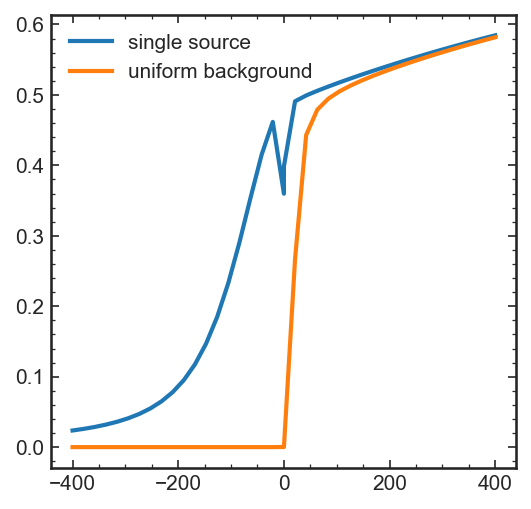

In [120]:
R_test = 1.41

tau_total_dict, R_ion_tab, xHI_01_tab = load_dict(r_slope=2., z_s=7., z_min=6.)
trans_minDV_dict, trans_DV_dict = get_transminDV_DVtrans(tau_total_dict)

DV = trans_DV_dict[R_test, -6][:,0]
T  = trans_DV_dict[R_test, -6][:,1]

plt.plot(DV, T, label='single source')

tau_total_dict, R_ion_tab, xHI_01_tab = load_dict(r_slope=0., z_s=7., z_min=6.)
trans_minDV_dict, trans_DV_dict = get_transminDV_DVtrans(tau_total_dict)

DV = trans_DV_dict[R_test, -4][:,0]
T  = trans_DV_dict[R_test, -4][:,1]

plt.plot(DV, T, label='uniform background')

plt.legend()


In [179]:
xHI_max = 1e-5
ionizing_background = 3. * bubbles.n_H(z=z_s) * bubbles.alpha_rec_B(T=1.e4)/xHI_max
print(ionizing_background)
print(ionizing_background/bubbles.Gamma12(6.6)*u.s)

6.6091299772676766e-12 1 / s
28.135930086282148


# Transmission blue, red etc 

## Multiply by transmission

Text(0, 0.5, 'Normalized Lya flux')

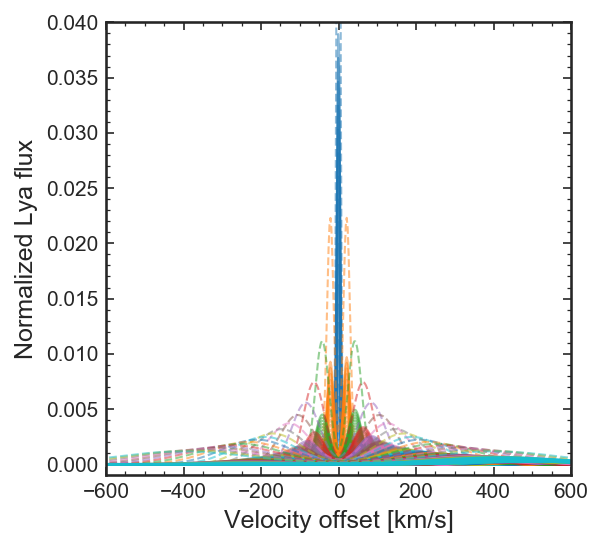

In [236]:
Tigm      = np.zeros((len(lines), len(tau_tot_tab)))
Tigm_blue = np.zeros((len(lines), len(tau_tot_tab)))
Tigm_red = np.zeros((len(lines), len(tau_tot_tab)))

for i, line in enumerate(lines):
    ln = plt.plot(velocity, line, lw=1, alpha=0.5, ls='dashed')
    
    trans_tot_tab = np.exp(-tau_tot_tab)
    plt.plot(velocity, (line*trans_tot_tab).T, c=ln[0].get_color(), lw=1, alpha=0.5)
    
    Tigm_blue[i] = 2*np.trapz(line[velocity < 0.]*trans_tot_tab.T[np.where(velocity < 0.)].T, velocity[velocity < 0.])
    Tigm_red[i]  = 2*np.trapz(line[velocity >= 0.]*trans_tot_tab.T[np.where(velocity >= 0.)].T, velocity[velocity >= 0.])
    Tigm[i]      = np.trapz(line*trans_tot_tab, velocity)
    
plt.xlim(-600, 600)
plt.ylim(-0.001, 0.04)
plt.xlabel('Velocity offset [km/s]')
plt.ylabel('Normalized Lya flux')

## Plot both transmissions

In [ ]:
plt.figure(figsize=(5.8, 5))

im = plt.pcolormesh(line_DV, R_ion_tab, Tigm_blue.T, cmap='Blues')
plt.colorbar(im, label=r'Fraction of blue peak observed')

# Tigm_levels = [0.001, 0.01, 0.1]
# linestyles=['solid', 'dashed', 'dotted']
Tigm_levels = [0.1]
cs = plt.contour(line_DV, R_ion_tab, Tigm_blue.T, levels=Tigm_levels, 
                 colors='k')

fmt = ticker.LogFormatterMathtext()
fmt.create_dummy_axis()

plt.clabel(cs, cs.levels, inline_spacing=20., fmt=fmt)

plt.ylabel('Bubble size [Mpc]')
plt.xlabel(r'Ly$\alpha$ velocity offset, $\Delta v_\alpha$ [km/s]')

plt.savefig('transmission_bubblesize_deltav_bluepeak.pdf', bbox_inches='tight')

## What is minimum R_HII required to see a blue peak?

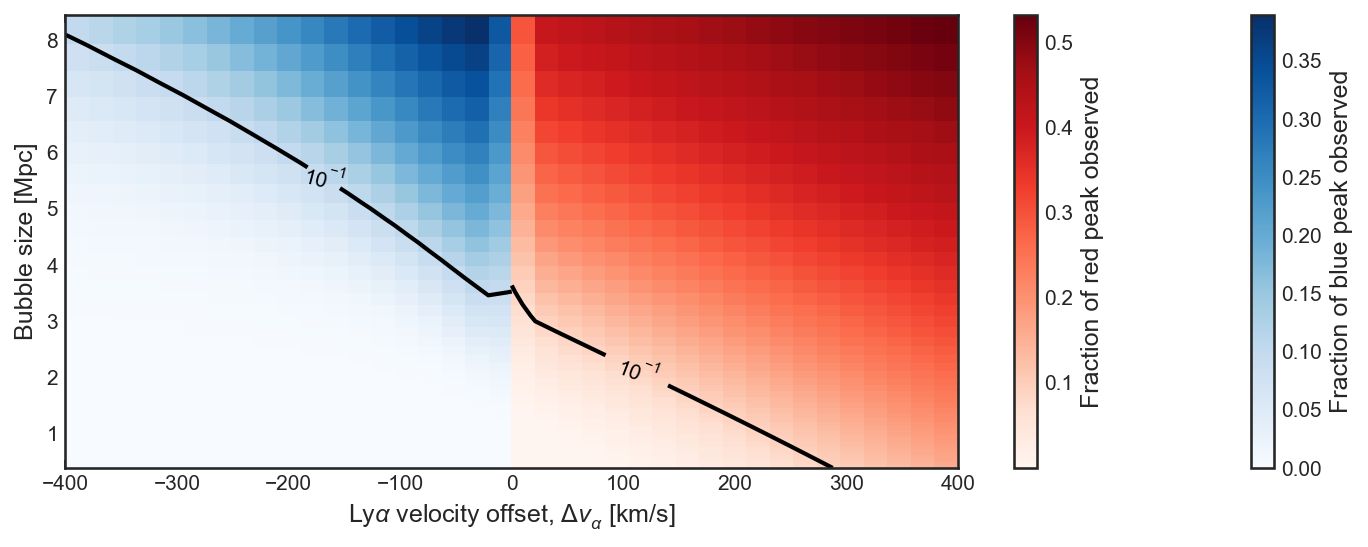

In [242]:
plt.figure(figsize=(12, 4))

im_blue = plt.pcolormesh(-line_DV, R_ion_tab, Tigm_blue.T, cmap='Blues')
plt.colorbar(im_blue, label=r'Fraction of blue peak observed')

# Tigm_levels = [0.001, 0.01, 0.1]
# linestyles=['solid', 'dashed', 'dotted']
Tigm_levels = [0.1]
cs = plt.contour(-line_DV, R_ion_tab, Tigm_blue.T, levels=Tigm_levels, 
                 colors='k')

fmt = ticker.LogFormatterMathtext()
fmt.create_dummy_axis()

plt.clabel(cs, cs.levels, inline_spacing=20., fmt=fmt)

im_red = plt.pcolormesh(line_DV, R_ion_tab, Tigm_red.T, cmap='Reds')

Tigm_levels = [0.001, 0.01, 0.1]
Tigm_levels = [0.1]

linestyles=['dotted', 'dashed', 'solid']
linestyles=['solid']
cs = plt.contour(line_DV, R_ion_tab, Tigm_red.T, levels=Tigm_levels, 
                 colors='k', linestyles=linestyles)

# ax.Tick.zorder = 1000
plt.clabel(cs, cs.levels, inline_spacing=20., fmt=fmt)
plt.colorbar(im_red, label=r'Fraction of red peak observed')

plt.ylabel('Bubble size [Mpc]')
plt.xlabel(r'Ly$\alpha$ velocity offset, $\Delta v_\alpha$ [km/s]')

plt.savefig('../figs/transmission_bubblesize_deltav.pdf', bbox_inches='tight')

In [250]:
print(np.exp(-5), np.exp(-7))

0.006737946999085467 0.0009118819655545162


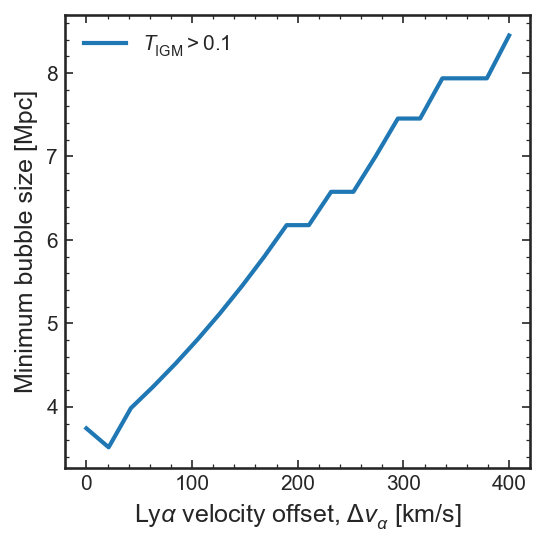

In [49]:
Tcut = 0.1
min_bubble_size = np.zeros(len(lines))
for i, line in enumerate(lines):
    min_bubble_size[i] = R_ion_tab[np.where(Tigm_blue[i] >= Tcut)[0][0]]

plt.plot(line_DV, min_bubble_size, label=r'$T_\mathrm{IGM} > %.1f$' % Tcut)

plt.legend()

plt.xlabel(r'Ly$\alpha$ velocity offset, $\Delta v_\alpha$ [km/s]')
plt.ylabel('Minimum bubble size [Mpc]')

plt.savefig('min_bubblesize_deltav.pdf', bbox_inches='tight')

## What is minimum R_HII required to see red peak?

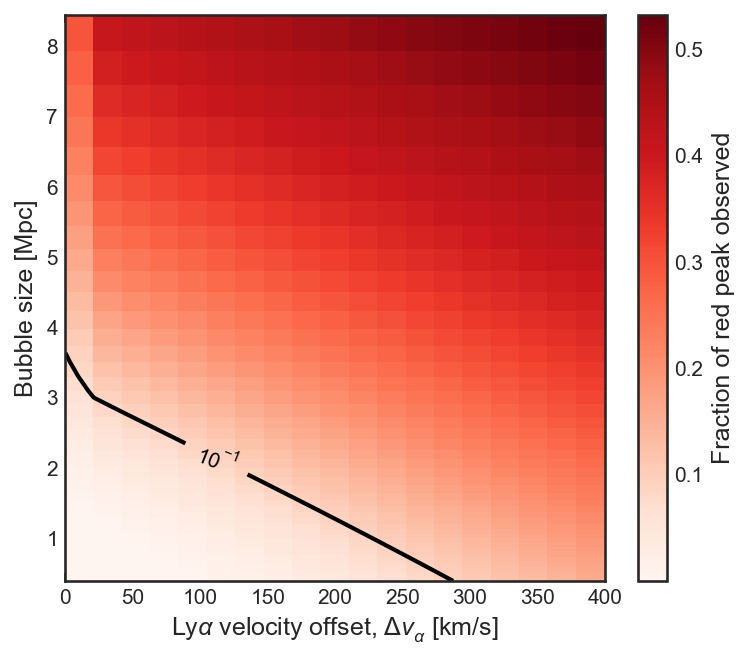

In [63]:
fig, ax = plt.subplots(1,1, figsize=(5.8, 5))

im = plt.pcolormesh(line_DV, R_ion_tab, Tigm_red.T, cmap='Reds')
# ax.set_yscale('log')

Tigm_levels = [0.001, 0.01, 0.1]
Tigm_levels = [0.1]

linestyles=['dotted', 'dashed', 'solid']
linestyles=['solid']
cs = plt.contour(line_DV, R_ion_tab, Tigm_red.T, levels=Tigm_levels, 
                 colors='k', linestyles=linestyles)

# fmt = ticker.LogFormatterMathtext()
# fmt.create_dummy_axis()

# locmin = mpl.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
# ax.yaxis.set_minor_locator(locmin)
# ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
# plt.minorticks_on()
# ax.Tick.zorder = 1000
plt.clabel(cs, cs.levels, inline_spacing=20., fmt=fmt)
plt.colorbar(im, label=r'Fraction of red peak observed')

plt.ylabel('Bubble size [Mpc]')
plt.xlabel(r'Ly$\alpha$ velocity offset, $\Delta v_\alpha$ [km/s]')

plt.savefig('transmission_bubblesize_deltav_redpeak.pdf', bbox_inches='tight')

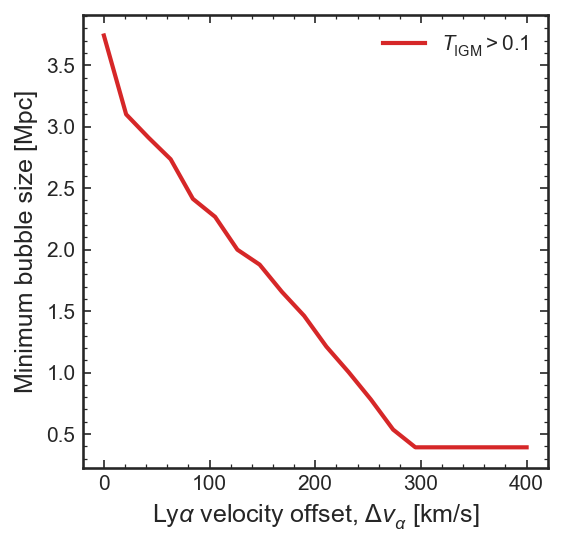

In [64]:
Tcut = 0.1
min_bubble_size = np.zeros(len(lines))
for i, line in enumerate(lines):
    min_bubble_size[i] = R_ion_tab[np.where(Tigm_red[i] >= Tcut)[0][0]]

plt.plot(line_DV, min_bubble_size, c='tab:red', label=r'$T_\mathrm{IGM} > %.1f$' % Tcut)

plt.legend()

plt.xlabel(r'Ly$\alpha$ velocity offset, $\Delta v_\alpha$ [km/s]')
plt.ylabel('Minimum bubble size [Mpc]')

plt.savefig('min_bubblesize_deltav_red.pdf', bbox_inches='tight')

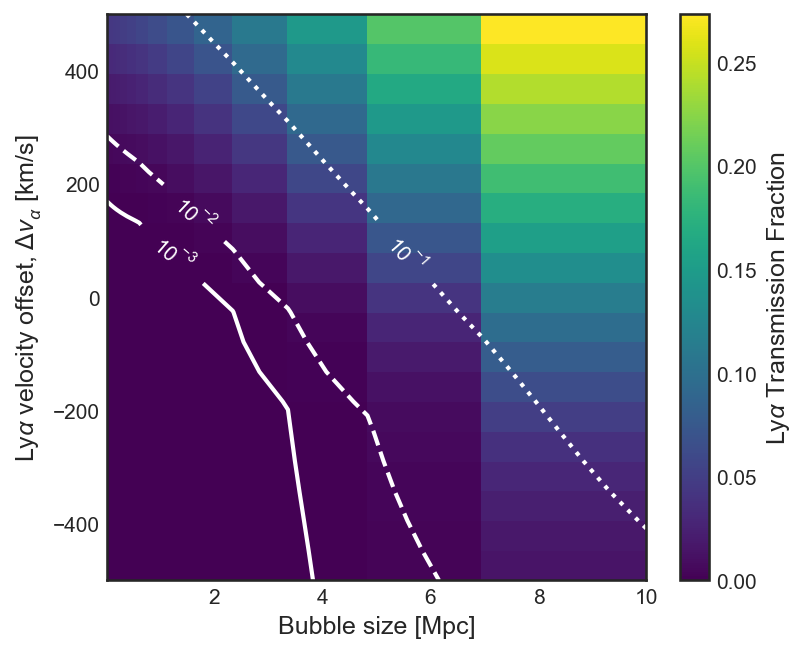

In [319]:
# reionizer.plot_image(Tigm, R_ion.value, line_DV,
#                      xlabel='Bubble size [Mpc]', 
#                      ylabel=r'Ly$\alpha$ velocity offset, $\Delta v_\alpha$ [km/s]', 
#                      cmap='viridis', clabel=r'Ly$\alpha$ Transmission Fraction')

plt.figure(figsize=(5.8, 5))

im = plt.pcolormesh(R_ion.value, line_DV, Tigm, cmap='viridis')
plt.colorbar(im, label=r'Ly$\alpha$ Transmission Fraction')

Tigm_levels = [0.001, 0.01, 0.1]
cs = plt.contour(R_ion.value, line_DV, Tigm, levels=Tigm_levels, 
                 colors='w', linestyles=['solid', 'dashed', 'dotted'])

fmt = ticker.LogFormatterMathtext()
fmt.create_dummy_axis()

plt.clabel(cs, cs.levels, fmt=fmt, inline_spacing=20.)

plt.xlabel('Bubble size [Mpc]')
plt.ylabel(r'Ly$\alpha$ velocity offset, $\Delta v_\alpha$ [km/s]')

plt.savefig('transmission_bubblesize_deltav.pdf', bbox_inches='tight')

Text(0, 0.5, 'Lya transmission')

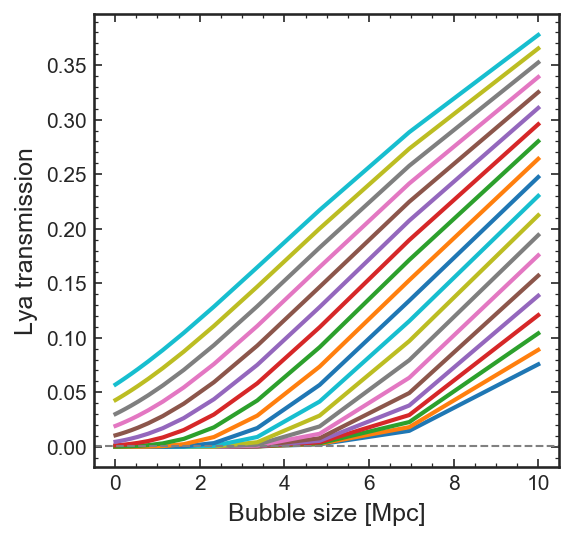

In [320]:
for i, line in enumerate(lines):
    plt.plot(R_ion, Tigm[i])
plt.axhline(1e-3, c='0.5', ls='dashed', lw=1)
plt.xlabel('Bubble size [Mpc]')
plt.ylabel('Lya transmission')

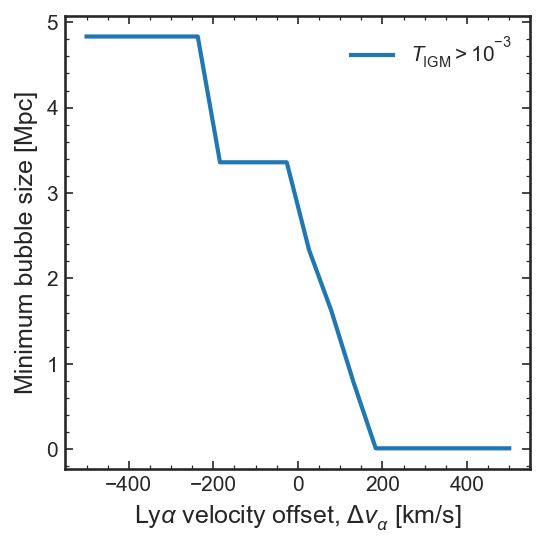

In [321]:
min_bubble_size = np.zeros(len(lines))
for i, line in enumerate(lines):
    min_bubble_size[i] = R_ion[np.where(Tigm[i] >= 1.e-3)[0][0]].value

plt.plot(line_DV, min_bubble_size, label=r'$T_\mathrm{IGM} > 10^{-3}$')

plt.legend()

plt.xlabel(r'Ly$\alpha$ velocity offset, $\Delta v_\alpha$ [km/s]')
plt.ylabel('Minimum bubble size [Mpc]')

plt.savefig('min_bubblesize_deltav.pdf', bbox_inches='tight')

## Grid of R_HII, xHI(0.1 Mpc) transmissions

### What is minimum R_HII and max xHI where DV is observable?

In [ ]:
trans_dict =  {}
for i, line in enumerate(lines):
    
    trans_dict[line_DV[i]] = {}
    for keys in tau_total_dict.keys():
    
        trans_tot_tab = np.exp(-tau_total_dict[keys])
        
        transmitted_line = line*trans_tot_tab.T
        
        Tigm_tot_grid  = np.trapz(transmitted_line, velocity)
        Tigm_blue_grid = 2*np.trapz(transmitted_line[velocity < 0.], velocity[velocity < 0.])
        Tigm_red_grid  = 2*np.trapz(transmitted_line[velocity >= 0.], velocity[velocity >= 0.])
        
        trans_dict[line_DV[i]][keys] = [Tigm_blue_grid, Tigm_red_grid, Tigm_tot_grid]

In [ ]:
T_min = 0.1
T_min01 = 0.01

R_xHI_trans_blue = {}
R_xHI_trans_red  = {}
for DV in trans_dict.keys():
    
    R_xHI_trans_blue[DV,T_min]  = []
    R_xHI_trans_blue[DV,T_min01]  = []
    R_xHI_trans_red[DV,T_min] = []
    R_xHI_trans_red[DV,T_min01] = []
    
    for keys in trans_dict[DV].keys():
        
        Tigm_blue_grid, Tigm_red_grid, Tigm_tot_grid = trans_dict[DV][keys]
        
        if Tigm_blue_grid > T_min:
            R_xHI_trans_blue[DV,T_min].append([keys[0].value, keys[1]])
        
        if Tigm_red_grid > T_min:
            R_xHI_trans_red[DV,T_min].append([keys[0].value, keys[1]])
        
        if Tigm_blue_grid > T_min01:
            R_xHI_trans_blue[DV,T_min01].append([keys[0].value, keys[1]])
        
        if Tigm_red_grid > T_min01:
            R_xHI_trans_red[DV,T_min01].append([keys[0].value, keys[1]])
            
    R_xHI_trans_blue[DV,T_min] = np.array(R_xHI_trans_blue[DV,T_min])
    R_xHI_trans_red[DV,T_min]  = np.array(R_xHI_trans_red[DV,T_min])
    
    R_xHI_trans_blue[DV,T_min01] = np.array(R_xHI_trans_blue[DV,T_min01])
    R_xHI_trans_red[DV,T_min01]  = np.array(R_xHI_trans_red[DV,T_min01])

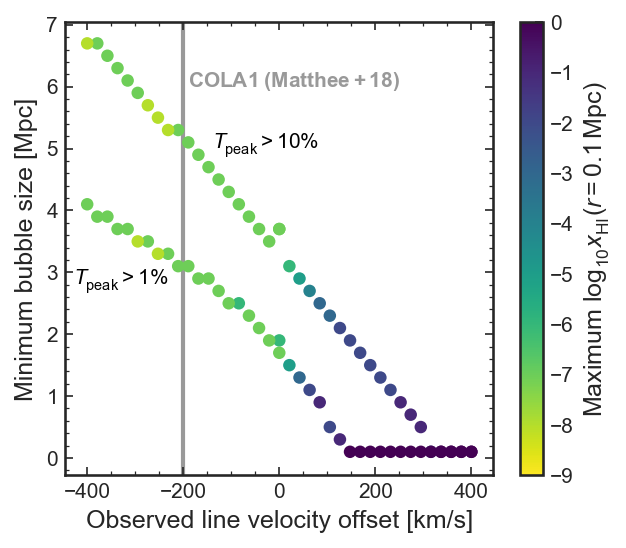

In [164]:
# Change xHI
s_m = bubbles.scalar_mappable(np.log10(xHI_01_tab), cmap='viridis_r')

plt.figure(figsize=(4.6,4))

observed_DV_tab_T_min = []
min_R_HII_tab_T_min   = []
max_xHI_tab_T_min     = []
observed_DV_tab_T_min01 = []
min_R_HII_tab_T_min01   = []
max_xHI_tab_T_min01     = []
for DV in trans_dict.keys():
    # T_min
    min_R_HII_array    = R_xHI_trans_blue[DV,T_min][np.where(R_xHI_trans_blue[DV,T_min][:,0] == np.min(R_xHI_trans_blue[DV,T_min][:,0]))]
    blue_max_xHI_array = min_R_HII_array[np.where(min_R_HII_array[:,1] == np.max(min_R_HII_array[:,1]))][0]

    min_R_HII_array   = R_xHI_trans_red[DV,T_min][np.where(R_xHI_trans_red[DV,T_min][:,0] == np.min(R_xHI_trans_red[DV,T_min][:,0]))]
    red_max_xHI_array = min_R_HII_array[np.where(min_R_HII_array[:,1] == np.max(min_R_HII_array[:,1]))][0]

    observed_DV_tab_T_min.append([-DV])
    min_R_HII_tab_T_min.append(blue_max_xHI_array[0])
    max_xHI_tab_T_min.append(blue_max_xHI_array[1])
    
    observed_DV_tab_T_min.append([DV])
    min_R_HII_tab_T_min.append(red_max_xHI_array[0])
    max_xHI_tab_T_min.append(red_max_xHI_array[1])
    
    # T_min_01
    min_R_HII_array    = R_xHI_trans_blue[DV,T_min01][np.where(R_xHI_trans_blue[DV,T_min01][:,0] == np.min(R_xHI_trans_blue[DV,T_min01][:,0]))]
    blue_max_xHI_array = min_R_HII_array[np.where(min_R_HII_array[:,1] == np.max(min_R_HII_array[:,1]))][0]

    min_R_HII_array   = R_xHI_trans_red[DV,T_min01][np.where(R_xHI_trans_red[DV,T_min01][:,0] == np.min(R_xHI_trans_red[DV,T_min01][:,0]))]
    red_max_xHI_array = min_R_HII_array[np.where(min_R_HII_array[:,1] == np.max(min_R_HII_array[:,1]))][0]

    observed_DV_tab_T_min01.append([-DV])
    min_R_HII_tab_T_min01.append(blue_max_xHI_array[0])
    max_xHI_tab_T_min01.append(blue_max_xHI_array[1])
    
    observed_DV_tab_T_min01.append([DV])
    min_R_HII_tab_T_min01.append(red_max_xHI_array[0])
    max_xHI_tab_T_min01.append(red_max_xHI_array[1])

observed_DV_tab_T_min = np.array(observed_DV_tab_T_min)
min_R_HII_tab_T_min   = np.array(min_R_HII_tab_T_min)
max_xHI_tab_T_min     = np.array(max_xHI_tab_T_min)

observed_DV_tab_T_min01 = np.array(observed_DV_tab_T_min01)
min_R_HII_tab_T_min01   = np.array(min_R_HII_tab_T_min01)
max_xHI_tab_T_min01     = np.array(max_xHI_tab_T_min01)

plt.annotate('$T_\mathrm{peak} > %.0f \%%$' % (T_min*100), xy=(-140, 5), xycoords='data', color='k')
plt.annotate('$T_\mathrm{peak} > %.0f \%%$' % (T_min01*100), xy=(-430, 2.8), xycoords='data', color='k')

plt.scatter(observed_DV_tab_T_min, min_R_HII_tab_T_min, c=s_m.to_rgba(max_xHI_tab_T_min))
plt.scatter(observed_DV_tab_T_min01, min_R_HII_tab_T_min01, c=s_m.to_rgba(max_xHI_tab_T_min01))

plt.axvline(-200., lw=2, c='0.6', zorder=0)
plt.annotate('$\mathbf{COLA1\;(Matthee+18)}$', xy=(-200+10, 6), xycoords='data', color='0.6')

plt.colorbar(s_m, label='Maximum $\log_{10} x_\mathrm{HI} (r=0.1\,$Mpc$)$')
plt.xlabel('Observed line velocity offset [km/s]')
plt.ylabel('Minimum bubble size [Mpc]')
# plt.yscale('log')
plt.savefig('../figs/transmission_bubblesize_deltav_xHI_linear_r=%.0f.pdf' % r_slope, bbox_inches='tight')

# Ionizing background model Khaire & Srianand 2019

[Khaire & Srianand 2019](https://arxiv.org/abs/1801.09693) fiducial quasar SED $\alpha=-1.8$. Which was found to reproduce the measured He II Lyman-α effective optical depths as a function of z and the epoch of He II reionization

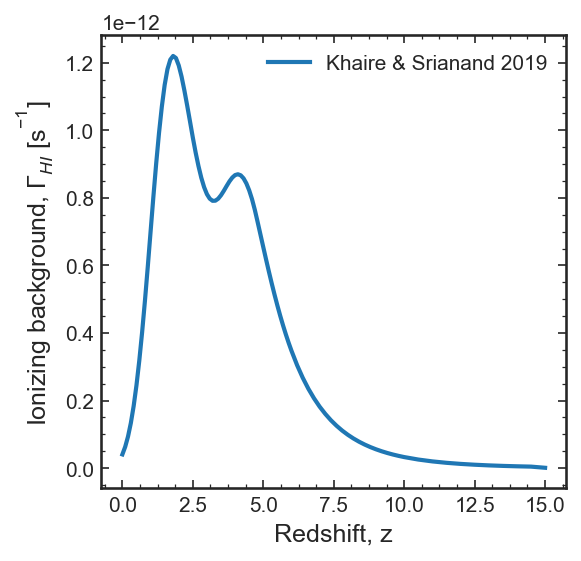

In [173]:
bubbles.plot_Gamma12_bg()

# Miralda-Escude approx for damping wing

In [80]:
R_alpha = 2.02e-8
Lambda  = 6.25e8 / u.s # decay constant for Lya resonance
n0      = 8.5e-5 * ((1. + z_s)/8.)**3. / (u.cm**3.)

z_s = 7.
z_min = 5.

def I(x):
    return x**4.5/(1-x) + 9./7.*x**3.5 + 9./5.*x**2.5 + 3*x**1.5 + 9*x**0.5 - 4.5*np.log((1+x**0.5)/(1-x**0.5))

def delta(DV, z_s):
    return (DV/const.c/(1+z_s)).value

def x1(DV, z_min, z_s):
    return (1+z_min)/(1+z_s)/(1+delta(DV, z_s))

def x2(DV, z_s):
    return 1./(1+delta(DV, z_s))

def tau0(z_s):
    return R_alpha / np.pi * (3*(1216.*u.Angstrom)**3. * Lambda * n0 / (8*np.pi * const.c * Planck15.H(z_s))).to(u.s/u.Mpc)

def tau0_2(z_s):
    Y = 0.24
    return R_alpha / np.pi * 2.1e5 * (Planck15.Om(z_s) * Planck15.h * (1-Y)/0.03) * (Planck15.H0 * (1+z_s)**1.5/Planck15.H(z_s)) * ((1.+z_s)/6.)**1.5

def tau0_Mesinger(z_s):
    tau = 6.43e-9 * bubbles.n_H(z_s) * bubbles.wave_Lya * 0.416 * np.pi * const.e.esu**2. / const.m_e / const.c / Planck15.H(z_s)
    return tau.to(u.cm/u.cm)
    
def tau_ME98(DV, z_min, z_s):
    return tau0_2(z_s) * (1+delta(DV, z_s))**1.5 * (I(x2(DV, z_s)) - I(x1(DV, z_min, z_s)))

def tau0_D14(z_s):
    return 7.5e5 * ((1+z_s)/10)**1.5

def tau_D14(DV, z_min, z_s):
    return tau0_D14(z_s) * R_alpha / np.pi * (1+delta(DV, z_s))**1.5 * (I(x2(DV, z_s)) - I(x1(DV, z_min, z_s)))

def tau_M15(DV, z_min, z_s):
    return tau0_Mesinger(z_s) (I((1+z_s)/8.) - I((1+z_min)/8.))

In [68]:
tau0(z_s), tau0_2(z_s), tau0_Mesinger(z_s)

(<Quantity 2.72442361e+11 s / Mpc>,
 <Quantity 0.06328301>,
 <Quantity 0.00264924>)

/anaconda2/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/anaconda2/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in subtract
  if __name__ == '__main__':


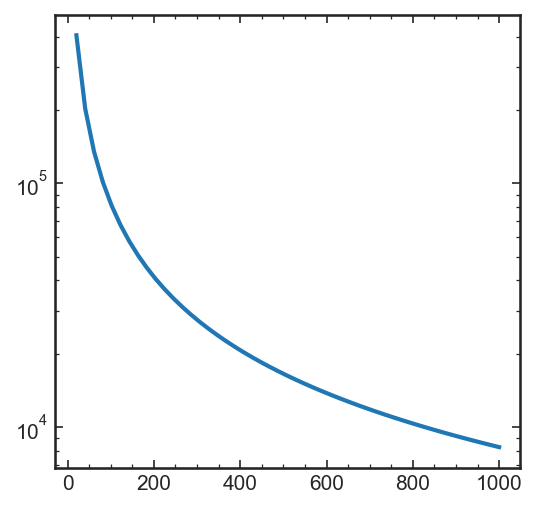

In [84]:
z_s = 7.
z_min = 5.

DV = np.linspace(0., 1000.)

# plt.semilogy(DV, tau_ME98(DV, z_min, z_s))
plt.semilogy(DV, tau_D14(DV, z_min, z_s))

# nH(z)

$$ n_{H, CH00} = 8.5\times10^{-5} \left(\frac{1+z}{8}\right)^3 \; \mathrm{cm}^{-3}$$

$$ n_{H, Madau} = \frac{1-Y}{m_p} \Omega_b(z) \rho_{crit}(z)$$

9.617207721982479e-05 1 / cm3
[0.88383242 0.88383242 0.88383242 0.88383242 0.88383242 0.88383242
 0.88383242 0.88383242 0.88383242 0.88383242 0.88383242 0.88383242
 0.88383242 0.88383242 0.88383242 0.88383242 0.88383242 0.88383242
 0.88383242 0.88383242 0.88383242 0.88383242 0.88383242 0.88383242
 0.88383242 0.88383242 0.88383242 0.88383242 0.88383242 0.88383242
 0.88383242 0.88383242 0.88383242 0.88383242 0.88383242 0.88383242
 0.88383242 0.88383242 0.88383242 0.88383242 0.88383242 0.88383242
 0.88383242 0.88383242 0.88383242 0.88383242 0.88383242 0.88383242
 0.88383242 0.88383242]
0.3075


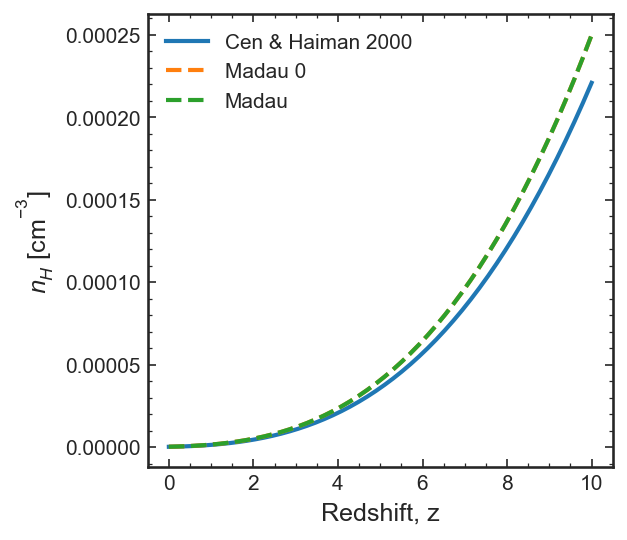

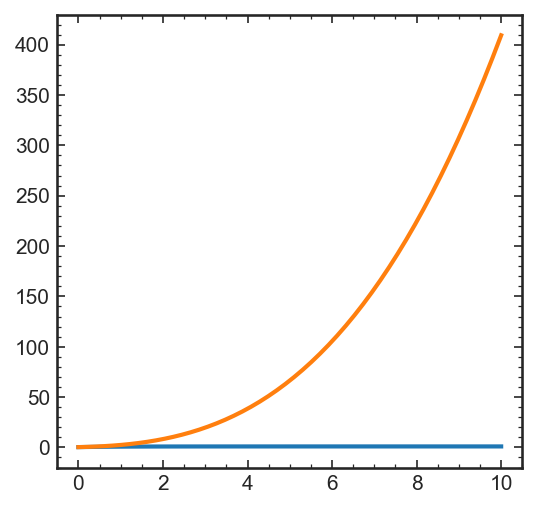

In [140]:
X_p = 0.75

ztab = np.linspace(0., 10)

def n_H(z):
    return (X_p * Planck15.Ob(z) * Planck15.critical_density(z) / const.m_p).to(u.cm**(-3.))

def n_H_0(z):
    return (X_p * Planck15.Ob0 * Planck15.critical_density0 * (1+z)**3. / const.m_p).to(u.cm**(-3.))


def n_H_CenHaiman(z):
    return 8.5e-5 * ((1. + z)/8.)**3. / (u.cm**3.)

plt.plot(ztab, n_H_CenHaiman(ztab), label='Cen & Haiman 2000')
plt.plot(ztab, n_H_0(ztab), ls='dashed', label='Madau 0')
plt.plot(ztab, n_H(ztab), ls='dashed', label='Madau')


plt.xlabel('Redshift, z')
plt.ylabel('$n_H$ [cm$^{-3}$]')
plt.legend()
print(n_H_0(0)*8**3.)
print(n_H_CenHaiman(ztab)/n_H(ztab))

print(Planck15.Om0)

plt.figure()
plt.plot(ztab, Planck15.Om(ztab))
plt.plot(ztab, Planck15.Om0 *(1+ztab)**3.)

# Optically thin radius

In [6]:
ztab = np.linspace(6, 10)

def f_R_opticallythin(r, z, tau_crit=-np.log(0.1), fesc=1., 
                       J_bg=1., C=3., T=1e4*u.K, 
                       qso=True, alpha=-1.8):   
        
    r = r*u.Mpc
    
    J_source_integrand = bubbles.L_nu(bubbles.nu_tab, qso=qso, alpha=alpha) * \
                         bubbles.sigma_ion/(bubbles.h_erg_s * bubbles.nu_tab)

    cross_sec = bubbles.lya_cross_section(T)
    
    a = C*bubbles.n_H(z)**2.*bubbles.alpha_rec_B(T.value)*cross_sec.sig_Lya0*u.cm**2./(1+z)
    b = tau_crit * J_bg * bubbles.Gamma12(z) / u.s
    c = tau_crit * fesc / 4. / np.pi * np.trapz(J_source_integrand, bubbles.nu_tab)
    
    a = a.to(1./u.Mpc/u.s)
    c = c.to(u.Mpc**2./u.s)
    
    f = a*r**3. - b*r**2. - c
    
    return f.value

R_solve = np.array([scipy.optimize.root_scalar(f_R_opticallythin, args=z, bracket=[0.01, 2]) for z in ztab])

In [7]:
def R_optically_thin(z, tau_crit=-np.log(0.1), fesc=1., 
                     C=3., T=1e4*u.K, J_bg=0., qso=True, alpha=-1.8):
    
    J_source_integrand = bubbles.L_nu(bubbles.nu_tab, qso=qso, alpha=alpha) * \
                         bubbles.sigma_ion/(bubbles.h_erg_s * bubbles.nu_tab)
    cross_sec = bubbles.lya_cross_section(T)
    
    a = C*bubbles.n_H(z)**2.*bubbles.alpha_rec_B(T.value) * cross_sec.sig_Lya0*u.cm**2./(1+z)
    c = tau_crit * fesc / 4. / np.pi * np.trapz(J_source_integrand, bubbles.nu_tab)
    R3 = c/a
    return (R3**(1./3)).to(u.Mpc)    

0.055415150038564 Mpc 1.158256984362052 Mpc


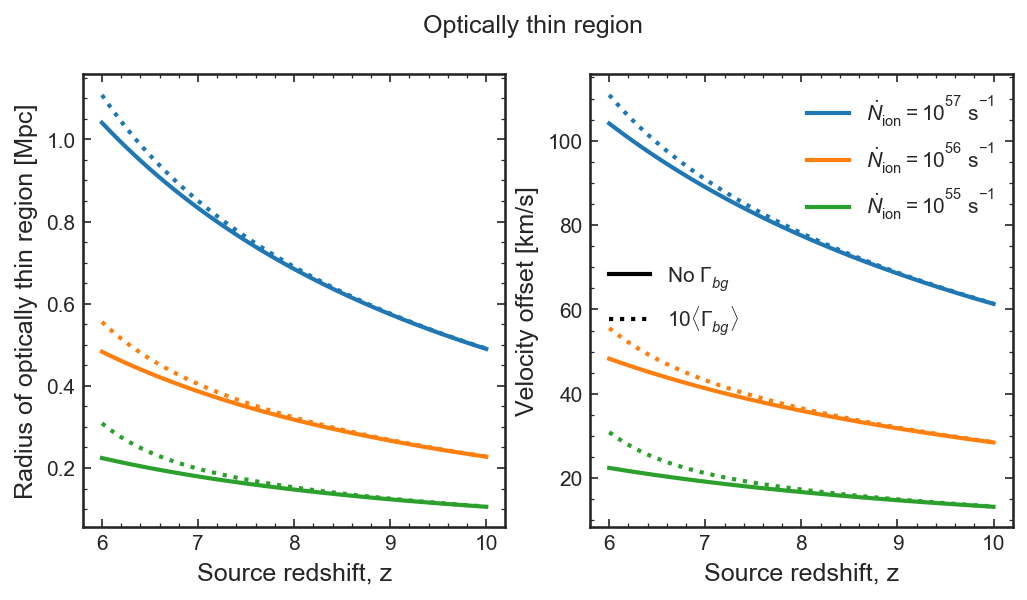

In [18]:
tau_crit = -np.log(0.01)
fesc = 1. 
J_bg = 1.

def Rcom_to_DV(Rcom, z):
    return (Rcom*Planck15.H(z)/(1.+z)).to(u.km/u.s)

# ax_r  = plt.subplot()
fig, (ax_r, ax_DV) = plt.subplots(1,2, figsize=(8,4))
# ax_DV = ax_r.twinx()

fesc_tab = [1, 0.1, 0.01]
for fesc in fesc_tab:
    
    Ndot_ion = bubbles.Ndot_ion_from_Lnu(bubbles.nu_tab, fesc=fesc/2., qso=True)

#     Rcom_optically_thin = R_optically_thin(ztab, fesc=fesc/2.)
#     ln = ax_r.plot(ztab, Rcom_optically_thin, 
#                    label='$\dot{N}_\mathrm{ion} = 10^{%.0f}$ s$^{-1}$' % np.log10(Ndot_ion.value))
    
    # With 10x UV background
    R_solve = np.array([scipy.optimize.root_scalar(f_R_opticallythin, \
                                                   args=(z, tau_crit, fesc/2, 10*J_bg), \
                                                   bracket=[0.01, 2]) for z in ztab])
    R_solved = np.array([R.root for R in R_solve])*u.Mpc
    
    # Plot
    ln = ax_r.plot(ztab, R_solved, ls='dotted')
    ax_DV.plot(ztab, Rcom_to_DV(R_solved, ztab), ls='dotted', c=ln[0].get_color())
    
    # No UV background
    R_solve = np.array([scipy.optimize.root_scalar(f_R_opticallythin, \
                                                   args=(z, tau_crit, fesc/2, 0.), \
                                                   bracket=[0.01, 2]) for z in ztab])
    R_solved_noBG = np.array([R.root for R in R_solve])*u.Mpc
    
    ax_r.plot(ztab, R_solved_noBG, c=ln[0].get_color())
    ax_DV.plot(ztab, Rcom_to_DV(R_solved_noBG, ztab),
               c=ln[0].get_color(), 
               label='$\dot{N}_\mathrm{ion} = 10^{%.0f}$ s$^{-1}$' % np.log10(Ndot_ion.value))


Rmin, Rmax = np.array(ax_r.get_ylim())*u.Mpc
print(Rmin, Rmax)
# ax_DV.set_ylim(Rcom_to_DV(Rmin, ztab.max()).value, Rcom_to_DV(Rmax, ztab.min()).value)


background_line   = mlines.Line2D([], [], color='k', lw=2, label=r'No $\Gamma_{bg}$')
nobackground_line = mlines.Line2D([], [], color='k', lw=2, ls='dotted', label=r'$10\langle \Gamma_{bg}\rangle$')

leg = plt.legend(handles=[background_line, nobackground_line], loc='center left')
ax_DV.add_artist(leg)

ax_DV.legend()

fig.suptitle('Optically thin region')
ax_r.set_ylabel('Radius of optically thin region [Mpc]')
ax_r.set_xlabel('Source redshift, z')
ax_DV.set_ylabel('Velocity offset [km/s]')
ax_DV.set_xlabel('Source redshift, z')

plt.savefig('../figs/R_optically_thin.pdf', bbox_inches='tight')

In [17]:
cross_sec = bubbles.lya_cross_section(1e4*u.K)

R3 = -np.log(0.01)/(4*np.pi*bubbles.n_H(0)**2. * bubbles.alpha_rec_B(1e4) * cross_sec.sig_Lya0 * u.cm**2) * 2.5e-18 * u.cm**2.
R3.to(u.Mpc**3.*u.s)

R3 *= 1e57/u.s*8e-5/3
R3.to(u.Mpc**3)
print((R3**(1/3)).to(u.Mpc))

print(R_optically_thin(z=0, fesc=0.5)*8e-5)

1.1551177129058368 Mpc
0.0016923986919914452 Mpc
